# Chapter 8 階層モデル

階層モデルはグループ差や個人差をうまく扱うための一手法である。具体的には「グループさを表すパラメータは類似しており、特定の分布から生成される」という仮定を置くことで、安定に推定できる上に解釈がしやすくなる。典型的には標準偏差$\sigma$の正規分布として、$\sigma$に無情報事前分布(一様分布)を設定してデータから推定する。

グループや個人あたりのデータが少ない場合に、階層モデルを使う。

## 8.1 階層モデルの導入

この節では大手4社の社員の年齢✕(歳)と年収Y(万円)のデータを扱う.40人分のカンマ区切りのファイルがあるとする(データファイル8.1, 1行が1人分)それぞれの列の説明は以下である。

[data-salary-2.txt](chap08/input/data-salary-2.txt)

X: 年齢。ただし実際の年齢から 23を引いてある。この理由は後述する
Y: 年収
KID: 勤務している会社のID(1~4の整数値)

年収とは基本年収と正規分布に従うその他の影響(ノイズ)の和であるとする。ここでグループ差は新卒の基本年収と年齢に伴う昇給額とする。

### 8.1.1 解析の目的とデータ分布の確認

各会社KIDにおける年齢Xと基本年収Yの関係を知りたい。「新卒の基本年収」と「年齢に伴う昇給額」の事後分布を作図する。

横軸に年齢・縦軸に年収をとった図を以下に示す

これを見ると、全体的に正の相関だが、KID=4はデータが3つのみで、負の相関が見えてしまう。これは過学習の一例。


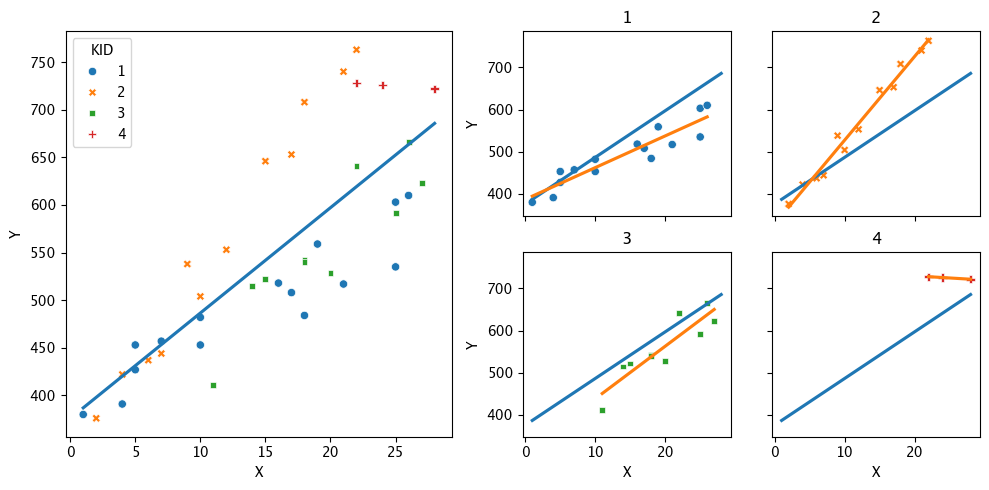

In [290]:
"""図8.1."""
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

data_salary_2 = Path("chap08/input/data-salary-2.txt")

salary2_df = pl.read_csv(data_salary_2)
salary2_df = salary2_df.with_columns(pl.col("KID").cast(str).cast(pl.Categorical))

fig = plt.figure(figsize=(10, 5))

# 左図のプロット
gs_master = GridSpec(2, 3, fig, width_ratios=[2, 1, 1])
gs_sub1 = GridSpecFromSubplotSpec(2, 1, gs_master[:, 0])
ax1 = fig.add_subplot(gs_sub1[:, :])
sns.scatterplot(
    salary2_df,
    x="X",
    y="Y",
    hue="KID",
    style="KID",
    ax=ax1,
)
sns.regplot(salary2_df, x="X", y="Y", ci=0, scatter=False, ax=ax1)

# 右図のプロット
gs_sub2 = GridSpecFromSubplotSpec(
    2,
    2,
    gs_master[:, 1:],
)
gs_subplot = gs_sub2.subplots(sharex="all", sharey="all")
for (name, kid_df), (row, col) in zip(
    salary2_df.group_by(pl.col("KID"), maintain_order=True),
    np.ndindex(2, 2),
    strict=True,
):
    ax = fig.add_subplot(gs_subplot[row, col])
    ax.set_title(name)

    sns.regplot(salary2_df, x="X", y="Y", ci=0, scatter=False, ax=ax)

    ax = sns.scatterplot(
        kid_df,
        x="X",
        y="Y",
        hue="KID",
        ax=ax,
        style="KID",
        legend=None,
    )
    sns.regplot(kid_df, x="X", y="Y", ci=0, scatter=False, ax=ax)

gs_master.tight_layout(fig)
plt.show()

### 8.1.2 グループ差を考えない場合

グループ差を考えずに１つの直線式a+ bXで考える。新卒の年齢は23とすると、Xは-23してあるので切片aはそのまま「新卒の基本年収」である。傾きbは「年齢に伴う昇給額」

モデル式は以下

モデル式 4-2(再掲)

$$
\begin{align}
Y[n] &= y_{base}[n] + \varepsilon[n] \quad &n = 1, \ldots, N \nonumber \\
y_{base}[n] &= a + b X[n] \quad &n = 1, \ldots, N \nonumber \\
\varepsilon[n] &\sim \mathrm{Normal}(0, \sigma_Y) \quad &n = 1, \ldots, N\nonumber  \\
\end{align}
$$

4.4節の単回帰と同じ。ここから$y_{base}[n]$と$\varepsilon[n]$を消去すると以下になる

モデル式8-1 (モデル式4-5と同じ)

$$
Y[n] \sim \mathrm{Normal}(a + b X[n], \sigma_Y) \quad n = 1, \ldots, N
$$

Stanで実装: [model8-1.stan](chap08/model/model8-1.stan)

以下のコードで得られたパラメータの中央値と95%ベイズ信頼区間について、グループ差を考えていないので、$\sigma_Y$がかなり大きく推定されている。

これも一つの解析ではあるが、グループ差と、それ以外の小さなノイズに切り分けてみる。

In [291]:
from pathlib import Path

import polars as pl
from cmdstanpy import CmdStanModel

data_salary_2 = Path("chap08/input/data-salary-2.txt")
salary2_df = pl.read_csv(data_salary_2)
salary2_df = salary2_df.with_columns(pl.col("KID").cast(str).cast(pl.Categorical))

data = {
    "N": salary2_df.shape[0],
    "X": salary2_df["X"].to_list(),
    "Y": salary2_df["Y"].to_list(),
}
sm1 = CmdStanModel(stan_file="chap08/model/model8-1.stan")
fit1 = sm1.sample(data=data, seed=1234)
fit1.summary()

23:50:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:50:19 - cmdstanpy - INFO - CmdStan done processing.


Mean      MCSE    StdDev         5%       50%       95%    N_Eff  \
lp__ -184.0880  0.032415   1.25644 -186.53700 -183.7770 -182.7160  1502.38   
a     376.3530  0.660942  24.30050  335.34300  376.3480  415.6900  1351.78   
b      11.0323  0.038213   1.40965    8.67922   11.0424   13.3454  1360.85   
s_Y    68.7506  0.194755   8.18917   56.60830   67.9429   82.8923  1768.08   

      N_Eff/s    R_hat  
lp__  13414.1  1.00012  
a     12069.4  1.00307  
b     12150.4  1.00202  
s_Y   15786.4  1.00170

### 8.1.3 グループごとに切片と傾きを持つ場合

モデル式8-2

$$
Y[n] \sim \mathrm{Normal}(a[KID[n]] + b[KID[n]] X[n], \sigma_Y) \quad n = 1, \ldots, N
$$

Stanで実装: [model8-2.stan](chap08/model/model8-2.stan)

結果は下のスクリプトになる。

会社ごとに直線の切片aと傾きbの推定値を得ることはできたが、各会社のa,bに付いて仮定が何もないため、このデータ以外の会社について予測ができない。

またデータ数が少ない会社などはうまく推定できない(b[4]がマイナス)、これは実際に欠損値が多いなどで起こりうる。その会社のデータを捨てるなどして対処するが、データをゆうこう有効活用できていない。

そこでモデルを考え直し、グループ差(会社差)に仮定を入れる。

In [292]:
from pathlib import Path

import polars as pl
from cmdstanpy import CmdStanModel

data_salary_2 = Path("chap08/input/data-salary-2.txt")
salary2_df = pl.read_csv(data_salary_2)

test = salary2_df["KID"]
xml = 1
data = {
    "N": salary2_df.shape[0],
    "K": salary2_df["KID"].unique_counts().shape[0],
    "X": salary2_df["X"].to_list(),
    "Y": salary2_df["Y"].to_list(),
    "KID": salary2_df["KID"].to_list(),
}
sm2 = CmdStanModel(stan_file="chap08/model/model8-2.stan")
fit2 = sm2.sample(data=data, seed=1234)
fit2.summary()

23:50:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:50:20 - cmdstanpy - INFO - CmdStan done processing.


Mean      MCSE      StdDev         5%        50%         95%  \
lp__ -148.08900  0.066818    2.413850 -152.33400 -147.79100  -144.77200   
a[1]  387.20200  0.263747   13.642900  364.65700  387.42800   408.88100   
a[2]  328.45900  0.315742   16.805500  301.00000  328.30200   356.18400   
a[3]  312.79300  0.636087   33.329400  257.20200  312.93800   367.39400   
a[4]  752.86700  3.376000  160.779000  486.25000  752.75400  1020.58000   
b[1]    7.51024  0.016458    0.850211    6.14290    7.49685     8.93156   
b[2]   19.88010  0.023312    1.242380   17.89760   19.87850    21.91350   
b[3]   12.51360  0.031649    1.645090    9.81205   12.54280    15.20710   
b[4]   -1.12406  0.135292    6.480880  -11.80350   -1.06432     9.51351   
s_Y    27.26678  0.068050    3.618580   22.06550   26.91470    33.78940   

          N_Eff     N_Eff/s     R_hat  
lp__  1305.0600  2171.48000  1.001160  
a[1]  2675.7000  4452.08000  1.000100  
a[2]  2832.9300  4713.69000  0.999839  
a[3]  2745.5000  4568.22000  0.999621  
a[4]  2268.0600  3773.80000  1.000920  
b[1]  2668.5600  4440.20000  1.000500  
b[2]  2840.1300  4725.67000  1.000440  
b[3]  2701.8900  4495.66000  0.999582  
b[4]  2294.7100  3818.14000  1.000880  
s_Y   2827.4972  4704.65424  1.000130

### 8.1.4 階層モデル

- メカニズムの想像
  
  切片a[k]に付いて、
  1. すべての会社で共通の平均
  2. 各会社の差: 平均0, 標準偏差$\sigma_a$の正規分布
   
  に分ける。傾きb[k]についても同様に考える。このようにゆるい制約を入れることで、会社差のばらつきを議論できるし、データ数が少なくてもa, bと$\sigma_a, \sigma_b$の推定に活かす事ができる。

  このとき$\sigma_a, \sigma_b$は無情報事前分布を設定する。階層的に事前分布を設定しているので階層モデル(hierarchical mddel)と呼ばれる。

- モデル式の記述

  モデル式 8-3

  $$
  \begin{align}
  Y[n] &\sim \mathrm{Normal }(a[KID[n]] + b[KID[n]] X[n], \sigma_Y) \quad &n = 1, \ldots, N \nonumber \\
  a[k] &= a_{全体平均} + a_{会社差}[k] \quad &k = 1, \ldots, K \nonumber \\
  a_{会社差}[k] &\sim \mathrm{Normal }(0, \sigma_a) \quad &k = 1, \ldots, K \nonumber \\
  b[k] &= b_{全体平均} + b_{会社差}[k] \quad &k = 1, \ldots, K \nonumber \\
  b_{会社差}[k] &\sim \mathrm{Normal }(0, \sigma_b) \quad &k = 1, \ldots, K \nonumber \\
  \end{align}
  $$

- R(Python)でシミュレーション

In [293]:
import numpy as np
import polars as pl

"""データ作成"""
r_gen = np.random.default_rng(seed=123)
N = 40
K = 4
N_k = (15, 12, 10, 3)
a0 = 350
b0 = 12
S_a = 60
S_b = 4
S_Y = 25
X = r_gen.choice(range(35), size=N, replace=True)
KID = np.repeat(range(1, K + 1), N_k, axis=0)

a = r_gen.normal(0, S_a, K) + a0
b = r_gen.normal(0, S_b, K) + b0
d = pl.DataFrame({"X": X, "KID": KID, "a": a[KID - 1], "b": b[KID - 1]})
d = d.with_columns(
    (pl.col("a") + pl.col("b") * pl.col("X") + r_gen.normal(scale=S_Y, size=N)).alias(
        "Y_sim",
    ),
)

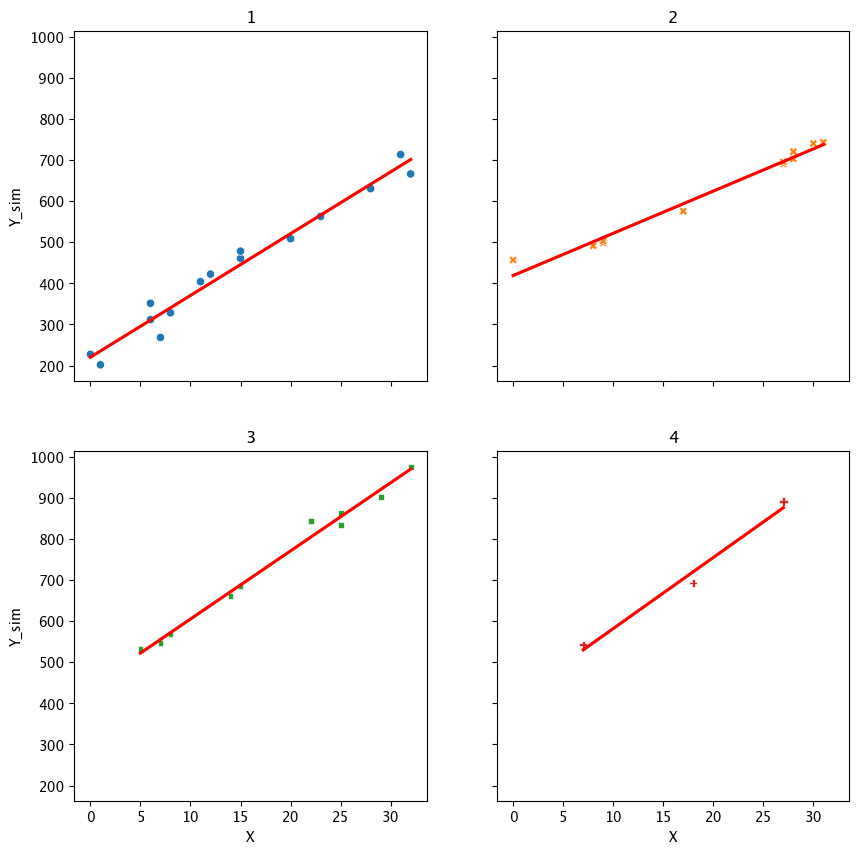

In [294]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

"""図8.2."""
d = d.with_columns(pl.col("KID").cast(str).cast(pl.Categorical))

fig, ax_tup = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax_tup = ax_tup.flatten()

for (name, kid_df), ax in zip(
    d.group_by(pl.col("KID"), maintain_order=True),
    ax_tup,
    strict=True,
):
    ax.set_title(name)
    sns.scatterplot(
        kid_df,
        x="X",
        y="Y_sim",
        hue="KID",
        style="KID",
        ax=ax,
        legend=False,
    )
    sns.regplot(kid_df, x="X", y="Y_sim", ci=0, scatter=False, ax=ax, color="red")


plt.show()

このシミュレーションが適切か判断する方法として、パラメータを変更しながら、どのような分布のデータが出やすいか確認すること。また、下記のようにStanで推定がうまくいくか確認する方法がある。

- Stanで実装: [model8-3.stan](chap08/model/model8-3.stan)

In [295]:
from pathlib import Path

from cmdstanpy import CmdStanModel

"""Stanでシミュレーション.
上で作成したデータはテキストのデータとかなり異なるため、
data-salary-2.txtを利用する.
"""
data_salary_2 = Path("chap08/input/data-salary-2.txt")
salary2_df = pl.read_csv(data_salary_2)

data = {
    "N": salary2_df.shape[0],
    "K": salary2_df["KID"].unique().shape[0],
    "X": salary2_df["X"].to_list(),
    "Y": salary2_df["Y"].to_list(),
    "KID": salary2_df["KID"].cast(str).cast(int).to_list(),
}
sm = CmdStanModel(stan_file="chap08/model/model8-3.stan")
fit3 = sm.sample(data, seed=1234)
fit3.summary(percentiles=(2, 98))

23:50:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:50:22 - cmdstanpy - INFO - CmdStan done processing.
23:50:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 iterations at max treedepth (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Mean      MCSE      StdDev         2%        98%       N_Eff  \
lp__  -172.958000  0.140290    3.364230 -180.63600 -166.77500   575.06700   
a0     374.330000  4.785370  112.446000  106.15100  650.28700   552.15400   
b0      12.133700  0.256138    6.428530   -3.68838   25.60590   629.90700   
ak[1]    8.916810  4.758060  111.935000 -266.95500  276.55700   553.44500   
ak[2]  -39.377800  4.778060  113.795000 -323.16200  218.27400   567.21300   
ak[3]  -48.651600  4.854020  115.532000 -344.46300  209.29500   566.50100   
ak[4]  112.062000  6.557030  161.248000 -106.20100  574.48600   604.75200   
bk[1]   -4.380780  0.254047    6.407260  -17.70460   11.23840   636.08400   
bk[2]    7.263040  0.258727    6.527890   -6.17688   23.74220   636.59700   
bk[3]   -0.235224  0.260334    6.568930  -13.25770   15.92500   636.69100   
bk[4]   -2.528650  0.288004    7.723860  -21.40150   12.37160   719.23600   
s_a    162.644850  8.255020  207.880890    6.94654  766.91800   634.15161   
s_b     11.116160  0.371130    9.777080    3.08002   41.22920   694.02732   
s_Y     28.484740  0.111090    3.792440   21.87830   37.48980  1165.44329   
a[1]   383.247000  0.294394   14.989500  350.88000  413.24700  2592.47000   
a[2]   334.952000  0.343072   17.760400  298.41300  372.80300  2680.00000   
a[3]   325.678000  0.648142   33.360600  254.34300  391.47000  2649.27000   
a[4]   486.392000  5.179270  136.435000  301.65800  817.50600   693.93000   
b[1]     7.752890  0.016927    0.926683    5.90090    9.65089  2997.00000   
b[2]    19.396700  0.025040    1.311060   16.61800   22.10220  2741.35000   
b[3]    11.898400  0.030752    1.654620    8.65832   15.45600  2894.91000   
b[4]     9.605020  0.208145    5.503430   -3.82553   17.34220   699.09600   

          N_Eff/s     R_hat  
lp__    360.77000  1.005200  
a0      346.39500  1.012610  
b0      395.17300  1.002470  
ak[1]   347.20500  1.013020  
ak[2]   355.84200  1.011990  
ak[3]   355.39600  1.011750  
ak[4]   379.39300  1.009400  
bk[1]   399.04900  1.002500  
bk[2]   399.37000  1.002000  
bk[3]   399.42900  1.002300  
bk[4]   451.21500  1.001320  
s_a     397.83664  1.007490  
s_b     435.39983  1.005870  
s_Y     731.14385  1.001550  
a[1]   1626.39000  0.999331  
a[2]   1681.30000  1.000380  
a[3]   1662.03000  0.999699  
a[4]    435.33900  1.000570  
b[1]   1880.18000  0.999293  
b[2]   1719.79000  0.999796  
b[3]   1816.13000  0.999614  
b[4]    438.58000  1.000790

### 8.1.5 モデルの比較

ここまでで作成したモデル式 8-1, 8-2, 8-3を比較

- グラフィカルモデルでの比較

![Alt text](chap08/output/fig8-3-left.png)![Alt text](chap08/output/fig8-3-center.png)![Alt text](chap08/output/fig8-3-right.png)

- 推定されたa[k]や、a[k], b[k]から計算される基本年収についてグラフで比較
  
  左図(推定されたa[k]の差異)ではモデル8-3の方が8-2よりデータ全体から求めたa(横線)に近い事がわかる。8-3の階層モデルでは、「各a[k]は類似しており、特定の分布から生成される」という仮定があるから。
  このように階層モデルと、階層モデルでないものを比べると、階層モデルのほうが推定値が縮む(狭まる)ことをshrinkageと呼ぶ。

  右図(各モデルの基本年収の中央値の回帰直線)では、KID=4で階層モデルの仮定を反映してるため、過学習を回避している。



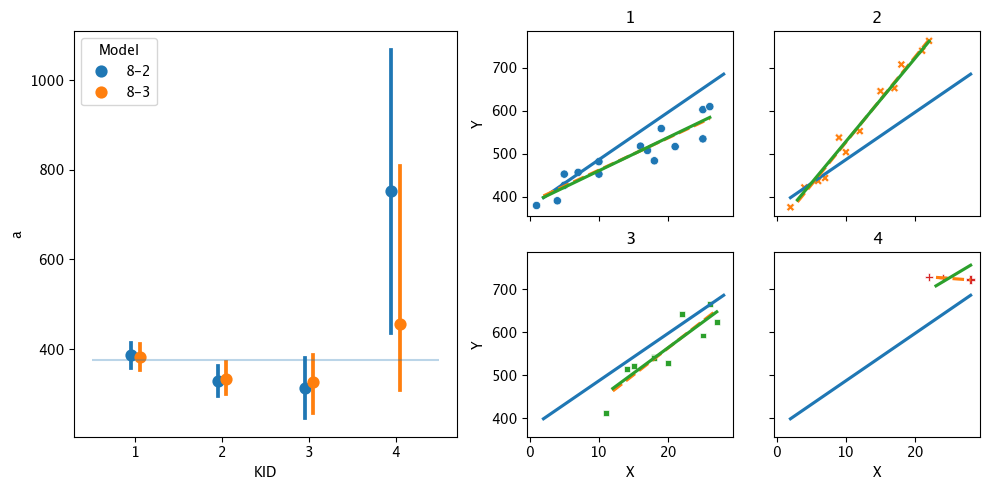

In [296]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from cmdstanpy import CmdStanMCMC
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from polars import DataFrame

"""図8.4."""
# グラフ描画用のa[k]のデータを調整
N_mcmc = fit2.a.shape[0]
K = fit2.a.shape[1]

a_8_2 = pl.DataFrame(
    np.stack(
        [
            fit2.a.flatten("F"),
            np.repeat(np.arange(K) + 1, N_mcmc),
            ["8-2"] * (K * N_mcmc),
        ],
    ).T,
    schema=["a", "KID", "Model"],
)

a_8_3 = pl.DataFrame(
    np.stack(
        [
            fit3.a.flatten("F"),
            np.repeat(np.arange(K) + 1, N_mcmc),
            ["8-3"] * (K * N_mcmc),
        ],
    ).T,
    schema=["a", "KID", "Model"],
)

a_total_df = pl.concat([a_8_2, a_8_3])
a_total_df = a_total_df.with_columns(
    pl.col("a").cast(float),
    pl.col("KID").cast(str).cast(pl.Categorical),
    pl.col("Model").cast(str).cast(pl.Categorical),
)

# 全体レイアウト
fig = plt.figure(figsize=(10, 5))
gs_master = GridSpec(2, 3, fig, width_ratios=[2, 1, 1])

# 左図をプロット
# 左図のレイアウト決定
gs_sub1 = GridSpecFromSubplotSpec(2, 1, gs_master[:, 0])
ax1 = fig.add_subplot(gs_sub1[:, :])

# モデル8-2, 8-3のa[k]の中央値と95%信頼区間
sns.pointplot(
    a_total_df,
    x="KID",
    y="a",
    hue="Model",
    dodge=0.1,
    linestyle="none",
    estimator="median",
    errorbar=("pi", 95),  # ベイズ推定値の信頼区間はpi(percentile interval)で出す
    ax=ax1,
)
# モデル8-1(全会社データを使った)a予測値の平均値を描画(横線)
xmin, xmax = ax1.get_xlim()
ax1.hlines(np.median(fit1.a), xmin, xmax, alpha=0.3)

# 右図をプロット
# 右図のレイアウト作成
gs_sub2 = GridSpecFromSubplotSpec(2, 2, gs_master[:, 1:])
gs_subplot = gs_sub2.subplots(sharex="all", sharey="all")

# 元データの再読み込み
data_salary_2 = Path("chap08/input/data-salary-2.txt")
salary2_df = pl.read_csv(data_salary_2)
salary2_df = salary2_df.with_columns(pl.col("KID").cast(str).cast(pl.Categorical))

# モデル8-1のデータの作成
dx = salary2_df.group_by("KID", maintain_order=True).agg(
    [pl.min("X").alias("Xmin"), pl.max("X").alias("Xmax")],
)
X_new = np.arange(dx["Xmin"].min(), dx["Xmax"].max()) + 1

# 基本年収Yの中央値を計算
y_base_mcmc1 = fit1.a.reshape((-1, 1)) + np.outer(fit1.b, X_new)
y_base_med1 = np.median(y_base_mcmc1, axis=0)

d1 = pl.DataFrame(
    {
        "X": X_new,
        "Y": y_base_med1,
        "Model": "8-1",
    },
    schema={"X": int, "Y": float, "Model": pl.Utf8},
)


def generate_data(dx: DataFrame, fit: CmdStanMCMC, model: str) -> DataFrame:
    """モデル8-2, 8-3のデータの作成."""
    result_df = pl.DataFrame(
        schema={"X": int, "Y": float, "KID": pl.Utf8, "Model": pl.Utf8},
    )
    for row_dict in dx.iter_rows(named=True):
        kid = row_dict["KID"]
        idx = int(kid) - 1

        x_new = np.arange(int(row_dict["Xmin"]), int(row_dict["Xmax"])) + 1

        # 基本年収Yの中央値を計算
        y_base_mcmc = fit.a[:, idx].reshape((-1, 1)) + np.outer(fit.b[:, idx], x_new)
        y_new = np.median(y_base_mcmc, axis=0)
        result_df = pl.concat(
            [
                result_df,
                pl.DataFrame({"X": x_new, "Y": y_new, "KID": kid, "Model": model}),
            ],
        )
    return result_df


d2 = generate_data(dx, fit2, "8-2")
d3 = generate_data(dx, fit3, "8-2")

# 右図のプロット
for kid, (row, col) in enumerate(np.ndindex(2, 2), start=1):
    ax = fig.add_subplot(gs_subplot[row, col])
    ax.set_title(kid)

    # 会社毎の元データの散布図
    sns.scatterplot(
        salary2_df.filter(pl.col("KID") == str(kid)),
        x="X",
        y="Y",
        hue="KID",
        ax=ax,
        style="KID",
        legend=None,
    )
    # モデル8-1の回帰直線
    sns.regplot(d1, x="X", y="Y", ci=0, scatter=False, ax=ax)

    # モデル8-2の回帰直線
    sns.regplot(
        d2.filter(pl.col("KID") == str(kid)),
        x="X",
        y="Y",
        ci=0,
        scatter=False,
        ax=ax,
        line_kws={"linestyle": "dashed"},
    )
    # モデル8-3の回帰直線
    sns.regplot(
        d3.filter(pl.col("KID") == str(kid)),
        x="X",
        y="Y",
        ci=0,
        scatter=False,
        ax=ax,
    )


gs_master.tight_layout(fig)
plt.show()

### 8.1.6 階層モデルの等価な表現

4.4.3ではモデル式の等価表現について学んだが、階層モデルにも適用できる。

「すべての会社の平均$a_{全体平均}, b_{全体平均}$から、各社の$a[k], b[k]$は全体平均を平均とした正規分布から生成された」と考えると会社差を消去できる。

8-3と8-4は等価だが、Stanで実装したときの計算速度や収束のしやすさが異なる(8-4のほうが速い)。複数の階層を持つモデルでは早くなりやすい。ただしモデルによっては逆の場合もある。

モデル式 8-4

$$
\begin{align}
Y[n] &\sim \mathrm{Normal }(a[KID[n]] + b[KID[n]] X[n], \sigma_Y) \quad &n = 1, \ldots, N \nonumber \\
a[k] &\sim \mathrm{Normal }(a_{全体平均}, \sigma_a) \quad &k = 1, \ldots, K \nonumber \\
b[k] &\sim \mathrm{Normal }(b_{全体平均}, \sigma_b) \quad &k = 1, \ldots, K \nonumber \\
\end{align}
$$

実装: [model8-4.stan](chap08/model/model8-4.stan)


In [297]:
import polars as pl
from cmdstanpy import CmdStanModel

data_salary_2 = Path("chap08/input/data-salary-2.txt")
salary2_df = pl.read_csv(data_salary_2)

data = {
    "N": salary2_df.shape[0],
    "K": salary2_df["KID"].max(),
    "X": salary2_df["X"].to_list(),
    "Y": salary2_df["Y"].to_list(),
    "KID": salary2_df["KID"].to_list(),
}

sm = CmdStanModel(stan_file="chap08/model/model8-4.stan")
fit = sm.sample(data, seed=1234)
fit.summary()

23:50:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:50:25 - cmdstanpy - INFO - CmdStan done processing.
23:50:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 107 divergent transitions (10.7%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 28 divergent transitions (2.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Mean      MCSE      StdDev          5%        50%        95%  \
lp__ -173.28800  0.139078    3.432170 -179.481000 -172.84500 -168.39300   
a0    384.69200  5.320560  142.414000  246.249000  370.42100  588.75700   
b0     12.45000  0.617008    9.659470    1.648490   12.52550   24.57090   
a[1]  384.09100  0.390528   14.811500  359.341000  383.86700  408.50500   
a[2]  335.96100  1.599760   18.428900  306.485000  335.14300  369.32200   
a[3]  325.46200  1.451380   35.015900  264.758000  326.84300  377.85200   
a[4]  485.28500  5.324240  134.134000  329.695000  451.57600  744.11100   
b[1]    7.70050  0.024064    0.915531    6.215850    7.71609    9.19182   
b[2]   19.27740  0.150685    1.412670   16.514300   19.36610   21.41920   
b[3]   11.91480  0.050852    1.703250    9.272200   11.83090   14.82650   
b[4]    9.62673  0.214978    5.396600   -0.745099   10.99660   16.06880   
s_a   172.13505  9.788320  248.060350   14.145000   98.74390  547.48800   
s_b    12.09330  0.586280   13.289290    3.730640    8.45390   32.73590   
s_Y    28.48677  0.106670    3.855920   23.045700   27.99380   35.39980   

           N_Eff     N_Eff/s    R_hat  
lp__   609.00300   698.39800  1.01046  
a0     716.46000   821.62800  1.00690  
b0     245.09000   281.06700  1.01428  
a[1]  1438.44000  1649.59000  1.00371  
a[2]   132.70500   152.18400  1.03926  
a[3]   582.06100   667.50100  1.00834  
a[4]   634.69300   727.85900  1.01147  
b[1]  1447.47000  1659.95000  1.00382  
b[2]    87.88980   100.79100  1.05106  
b[3]  1121.86000  1286.54000  1.00505  
b[4]   630.16100   722.66100  1.01145  
s_a    642.24133   736.51529  1.00864  
s_b    513.79172   589.21069  1.01321  
s_Y   1306.61475  1498.41141  1.00332

## 8.2 複数の階層を持つ階層モデル

8.1節で扱った[data-salary-2.txt](chap08/input/data-salary-2.txt)は実はある業界の大手4社のデータだったとする。ここでは、更に他の２つの業界のデータを追加した[data-salary-3.txt](chap08/input/data-salary-3.txt)について考える。

新たにGID列(会社が所属する業界のID)が追加されている。サンプル数は300人、会社数は30社、業界数は3つ。

### 8.2.1 解析の目的とデータの分布の確認

目的:
1. それぞれの会社(KID)における年齢Xと基本年収Yの関係を知りたい
2. それぞれの業界(GID)における平均的な年齢Xと基本年収Yを知りたい
3. 業界による差はどれほどか知りたい

業界差を無視すればモデル式8-4が使えるが、背景知識や常識から業界差はa「新卒の基本年収」もb「年齢に伴う昇給額」でも無視できないと考えられる。

まずは散布図でデータを確認し、会社ごとの切片と傾きの分布図を作る

図8.5から切片と傾きは業界によって差がありそうということがわかる
図8.6からどの業界も切片と傾きの分布は山型の分布になりそうだが、正規分布家はわからない。GID=3の業界は他の業界より切片aの業界平均は高そう。ばらつきも小さそう。傾きbは業界平均は低そう。ばらつきは小さそう。

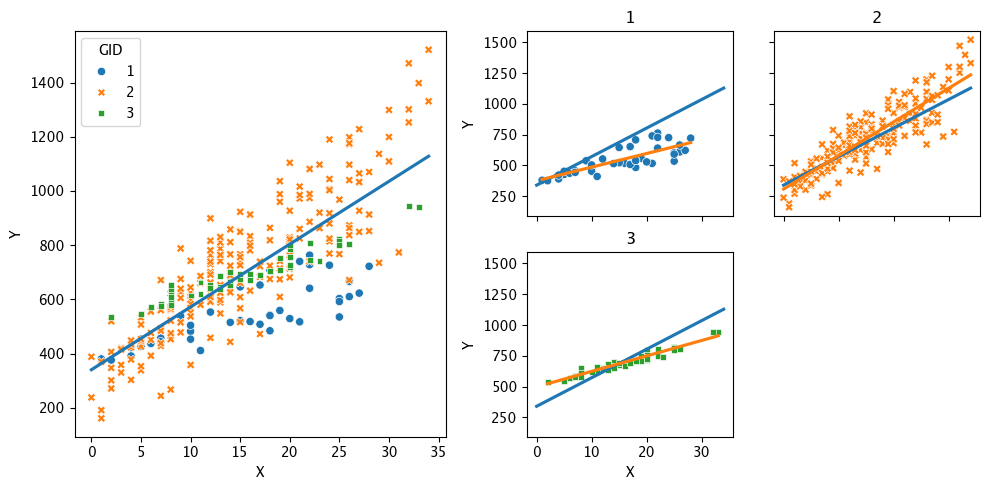

In [298]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

"""図8.5."""
data_salary_3 = Path("chap08/input/data-salary-3.txt")

salary3_df = pl.read_csv(data_salary_3)
salary3_df = salary3_df.with_columns(
    pl.col("KID").cast(str).cast(pl.Categorical),
    pl.col("GID").cast(str).cast(pl.Categorical),
)

fig = plt.figure(figsize=(10, 5))

# 左図のプロット
gs_master = GridSpec(2, 3, fig, width_ratios=[2, 1, 1])
gs_sub1 = GridSpecFromSubplotSpec(2, 1, gs_master[:, 0])
ax1 = fig.add_subplot(gs_sub1[:, :])
sns.scatterplot(
    salary3_df,
    x="X",
    y="Y",
    hue="GID",
    style="GID",
    ax=ax1,
)
sns.regplot(salary3_df, x="X", y="Y", ci=0, scatter=False, ax=ax1)

# 右図のプロット
gs_sub2 = GridSpecFromSubplotSpec(
    2,
    2,
    gs_master[:, 1:],
)
gs_subplot = gs_sub2.subplots(sharex="all", sharey="all")
for (name, kid_df), (row, col) in zip(
    salary3_df.group_by(pl.col("GID"), maintain_order=True),
    np.ndindex(2, 2),
    strict=False,
):
    ax = fig.add_subplot(gs_subplot[row, col])
    ax.set_title(name)

    sns.regplot(salary3_df, x="X", y="Y", ci=0, scatter=False, ax=ax)

    ax = sns.scatterplot(
        kid_df,
        x="X",
        y="Y",
        hue="GID",
        ax=ax,
        style="GID",
        legend=None,
    )
    sns.regplot(kid_df, x="X", y="Y", ci=0, scatter=False, ax=ax)
fig.delaxes(gs_subplot[1, 1])
gs_master.tight_layout(fig)
plt.show()

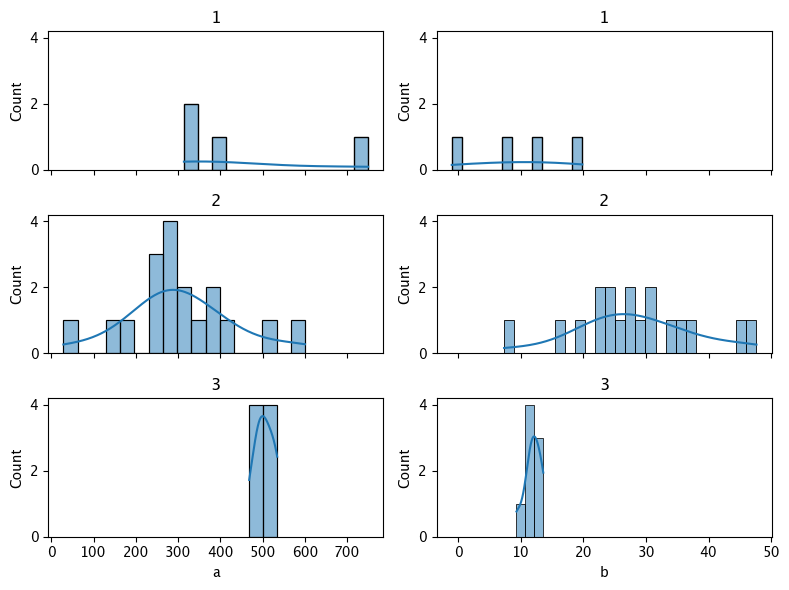

In [299]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

"""図8.6."""
data_salary_3 = Path("chap08/input/data-salary-3.txt")

salary3_df = pl.read_csv(data_salary_3)
salary3_df = salary3_df.with_columns(
    pl.col("KID").cast(str).cast(pl.Categorical),
    pl.col("GID").cast(str).cast(pl.Categorical),
)

gid1_df = pl.DataFrame(schema={"a": float, "b": float})
gid2_df = pl.DataFrame(schema={"a": float, "b": float})
gid3_df = pl.DataFrame(schema={"a": float, "b": float})

kid_df = pl.DataFrame(
    schema={"a": float, "b": float, "KID": pl.Categorical, "GID": pl.Categorical},
)
a_list = []
b_list = []
kid_list = []
gid_list = []

for (kid, gid), df in salary3_df.group_by(("KID", "GID"), maintain_order=True):
    a_b = np.polyfit(df["X"], df["Y"], 1)
    a_list.append(a_b[1])
    b_list.append(a_b[0])
    kid_list.append(kid)
    gid_list.append(gid)

kid_df = pl.DataFrame(
    data={
        "a": a_list,
        "b": b_list,
        "KID": kid_list,
        "GID": gid_list,
    },
    schema={"a": float, "b": float, "KID": pl.Categorical, "GID": pl.Categorical},
)
fig = plt.figure(figsize=(8, 6))
axes = fig.subplots(3, 2, sharex="col", sharey="col")
for i, (name, df) in enumerate(kid_df.group_by("GID", maintain_order=True)):
    ax_a = axes[i, 0]
    ax_a.set_title(name)
    sns.histplot(df, x="a", kde=True, ax=ax_a, binwidth=34)

    ax_b = axes[i, 1]
    ax_b.set_title(name)
    sns.histplot(df, x="b", kde=True, ax=ax_b, binwidth=1.6446)

plt.tight_layout()
plt.show()
# テキストと同じようなヒストグラムは書けなさそう

### 8.2.2 メカニズムの想像-その1

- a「新卒の基本年収」
- b「年齢に伴う昇給額」

まずはa, bの平均は業界差はあるが、会社差によるばらつきはないというシンプルなモデルを考える。

試しにaに付いて考えてみると、

[8.1.4項](#814-階層モデル)を参考に、
- $a_{業界平均}[g] = a_{全体平均} + a_{業界差}[g]$と考え
- $a_{業界差}[g] \sim \mathrm{Normal}(0, \sigma_{ag})$というゆるい制約を入れる。
- $\sigma_{ag}$には無情報事前分布を設定する

[8.1.6項](#816-階層モデルの等価な表現)に習って、$a_{業界差}[g]$を消去して、$a_{全体平均}$を平均とする正規分布から$a_{業界平均}[g]$が生成されると考えても良い
- $a_{業界平均}[g] \sim \mathrm{Normal}(a_{全体平均}, \sigma_{g})$

次に、各社のa[k]は、会社の所属する業界の$a_{業界平均}[g]$を平均とする正規
分布から生成されると考える。

- $a[k] \sim \mathrm{Normal}(a_{業界平均}[g], \sigma_{a})$

つまり、二段階の階層を持つ階層モデルとなっている。

### 8.2.3 モデル式の記述-その1

[8.1.6項](#816-階層モデルの等価な表現)のモデル式8-4の記法を使う.

モデル式8-5

- N:人数
- K:会社の数
- G:業界の数
- K2G[k]:会社kが所属している業界のGID(1~G)[<sup>1)</sup>](#fn1)


$$
\begin{align}
    Y[n] &\sim \mathrm{Normal }(a[KID[n]] + b[KID[n]] X[n], \sigma_Y) \quad &n = 1, \ldots, N \nonumber \\
    a_{業界平均}[g] &\sim \mathrm{Normal }(a_{全体平均}, \sigma_{ag}) \quad &g = 1, \ldots, G \nonumber \\
    b_{業界平均}[g] &\sim \mathrm{Normal }(b_{全体平均}, \sigma_{bg}) \quad &g = 1, \ldots, G \nonumber \\
    a[k] &\sim \mathrm{Normal }(a_{業界平均}[K2G[k]], \sigma_a) \quad &k = 1, \ldots, K \nonumber \\
    b[k] &\sim \mathrm{Normal }(b_{業界平均}[K2G[k]], \sigma_b) \quad &k = 1, \ldots, K \nonumber \\
\end{align}
$$


>[<sup id="fn1">1)</sup>](#fn1-back) KID to GID への変換ということでK2Gという変数名とした

### 8.2.4 Stanで実装-その1

実装: [model8-5.stan](chap08/model/model8-5.stan)

Rでの実行: [run-model8-5.R](chap08/run-model8-5.R)

23:50:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:50:30 - cmdstanpy - INFO - CmdStan done processing.
23:50:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 16 divergent transitions (1.6%)
	Chain 2 had 11 divergent transitions (1.1%)
	Chain 3 had 17 divergent transitions (1.7%)
	Chain 4 had 187 divergent transitions (18.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


array([[<Axes: title={'center': 'lp__'}>,
        <Axes: title={'center': 'lp__'}>]], dtype=object)

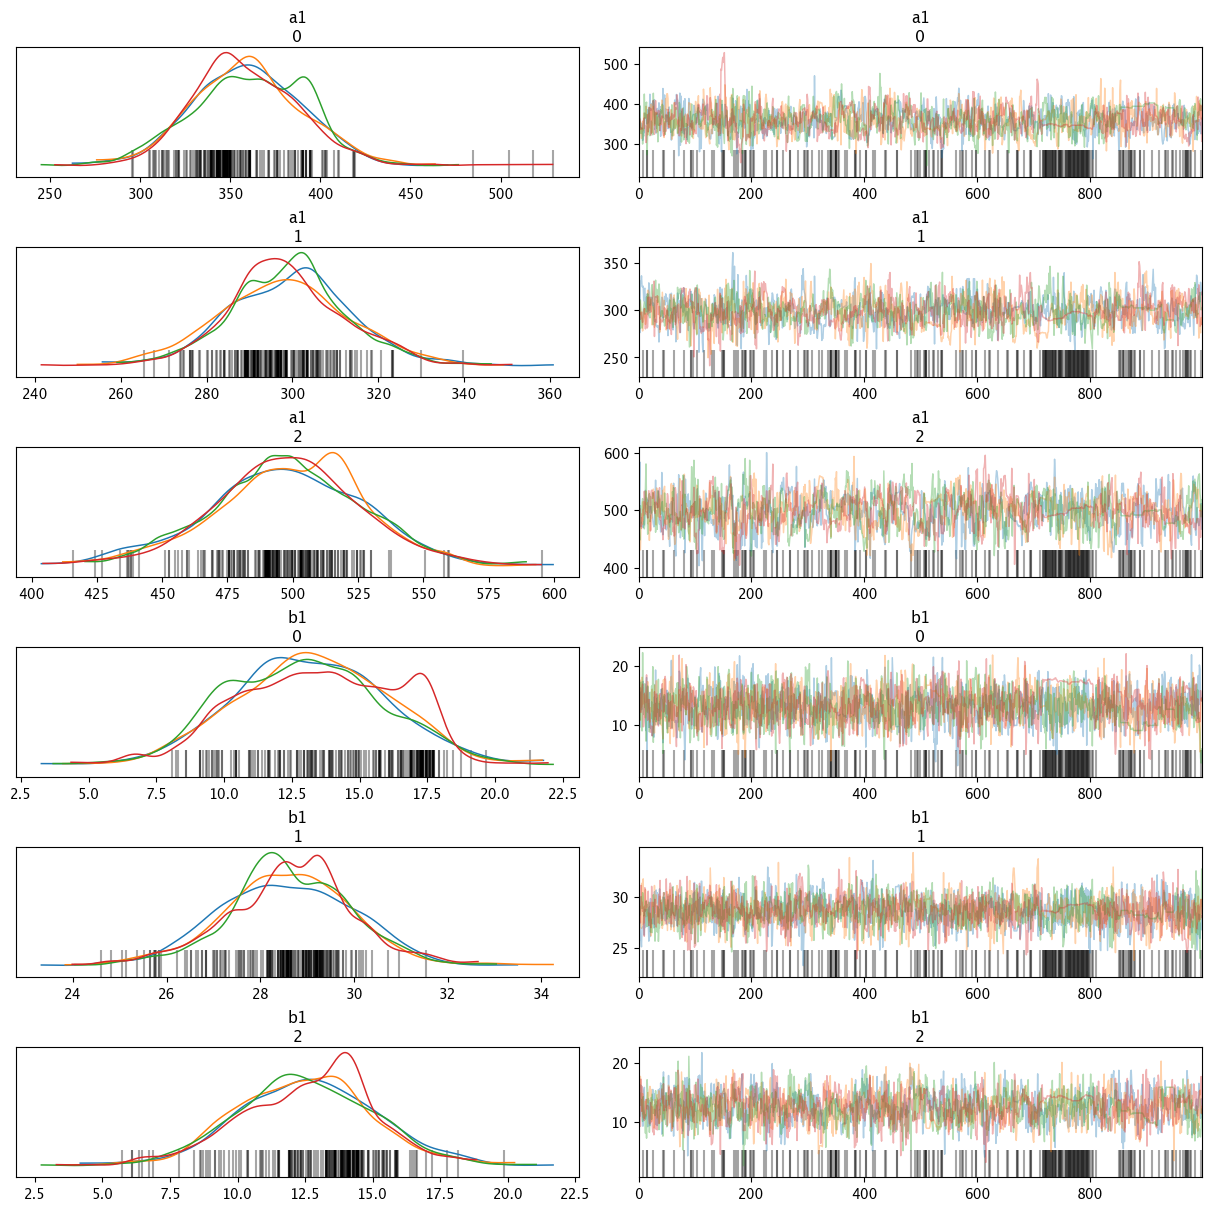

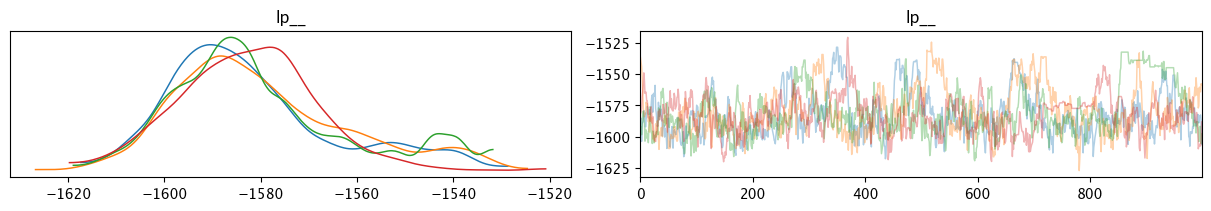

In [300]:
from pathlib import Path

import arviz as az
import polars as pl
from cmdstanpy import CmdStanModel

"""model8-5.stanの実行"""
data_salary_3 = Path("chap08/input/data-salary-3.txt")
salary3_df = pl.read_csv(data_salary_3)

data = {
    "N": salary3_df.shape[0],
    "G": salary3_df["GID"].max(),
    "K": salary3_df["KID"].max(),
    "X": salary3_df["X"].to_list(),
    "Y": salary3_df["Y"].to_list(),
    "KID": salary3_df["KID"].to_list(),
    "K2G": salary3_df.unique(subset=["KID", "GID"], maintain_order=True)[
        "GID"
    ].to_list(),
}
sm = CmdStanModel(stan_file="chap08/model/model8-5.stan")
fit = sm.sample(data=data, seed=12345)
fit.summary()

cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit,
    log_likelihood="lp__",
)

az.rcParams["plot.max_subplots"] = 200

ll_data = cmdstanpy_data.log_likelihood
az.plot_trace(
    cmdstanpy_data,
    var_names=["a1", "b1"],
    compact=False,
    backend_kwargs={"constrained_layout": True},
)
az.plot_trace(ll_data, compact=False, backend_kwargs={"constrained_layout": True})

### 8.2.5 メカニズムの想像-その2

[8.1.1項](#822-メカニズムの想像-その1)のモデル式8-5では、「新卒の基本年収」と「年齢に伴う昇給額」の会社差のばらつきは全業界共通で同じ値と仮定したが、その過程を緩め、会社差のばらつきを業界ごとに変える。また常識から、年齢以外の影響(ノイズ)の大きさ$\sigma_Y$も業界によって異なると思われる。

### 8.2.6モデル式の記述-その2

モデル式8-6

$$
\begin{align}
    Y[n] &\sim \mathrm{Normal }(a[KID[n]] + b[KID[n]] X[n], \sigma_Y[GID[n]]) \quad &n = 1, \ldots, N \nonumber \\
    a_{業界平均}[g] &\sim \mathrm{Normal }(a_{全体平均}, \sigma_{ag}) \quad &g = 1, \ldots, G \nonumber \\
    b_{業界平均}[g] &\sim \mathrm{Normal }(b_{全体平均}, \sigma_{bg}) \quad &g = 1, \ldots, G \nonumber \\
    a[k] &\sim \mathrm{Normal }(a_{業界平均}[K2G[k]], \sigma_a[K2G[k]]) \quad &k = 1, \ldots, K \nonumber \\
    b[k] &\sim \mathrm{Normal }(b_{業界平均}[K2G[k]], \sigma_b[K2G[k]]) \quad &k = 1, \ldots, K \nonumber \\
\end{align}
$$

### 8.2.7 Stanでの実装-その2

実装: [model8-6.stan](chap08/model/model8-6.stan)

このようにシンプルなモデルから複雑なモデル(モデル式8-5から8-6)にする過程で、MCMCが収束しなくなる事がある。モデルの複雑さに比べてデータが少ないことが原因として考えられる。

対策として、以下がある。
- 諦めてシンプルなモデルを使う
- 弱情報事前分布などを使って過程を増やす



23:50:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:50:35 - cmdstanpy - INFO - CmdStan done processing.
23:50:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/model/model8-6.stan', line 33, column 4 to column 43)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/model/model8-6.stan', line 34, column 4 to column 43)
Consider re-running with show_console=True if the above output is unclear!
23:50:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 18 divergent transitions (1.8%)
	Chain 2 had 33 divergent transitions (3.3%)
	Chain 3 had 63 divergent transitions (6.3%)
	Chain 4 had 15 divergent transitions (1.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


array([[<Axes: title={'center': 'lp__'}>,
        <Axes: title={'center': 'lp__'}>]], dtype=object)

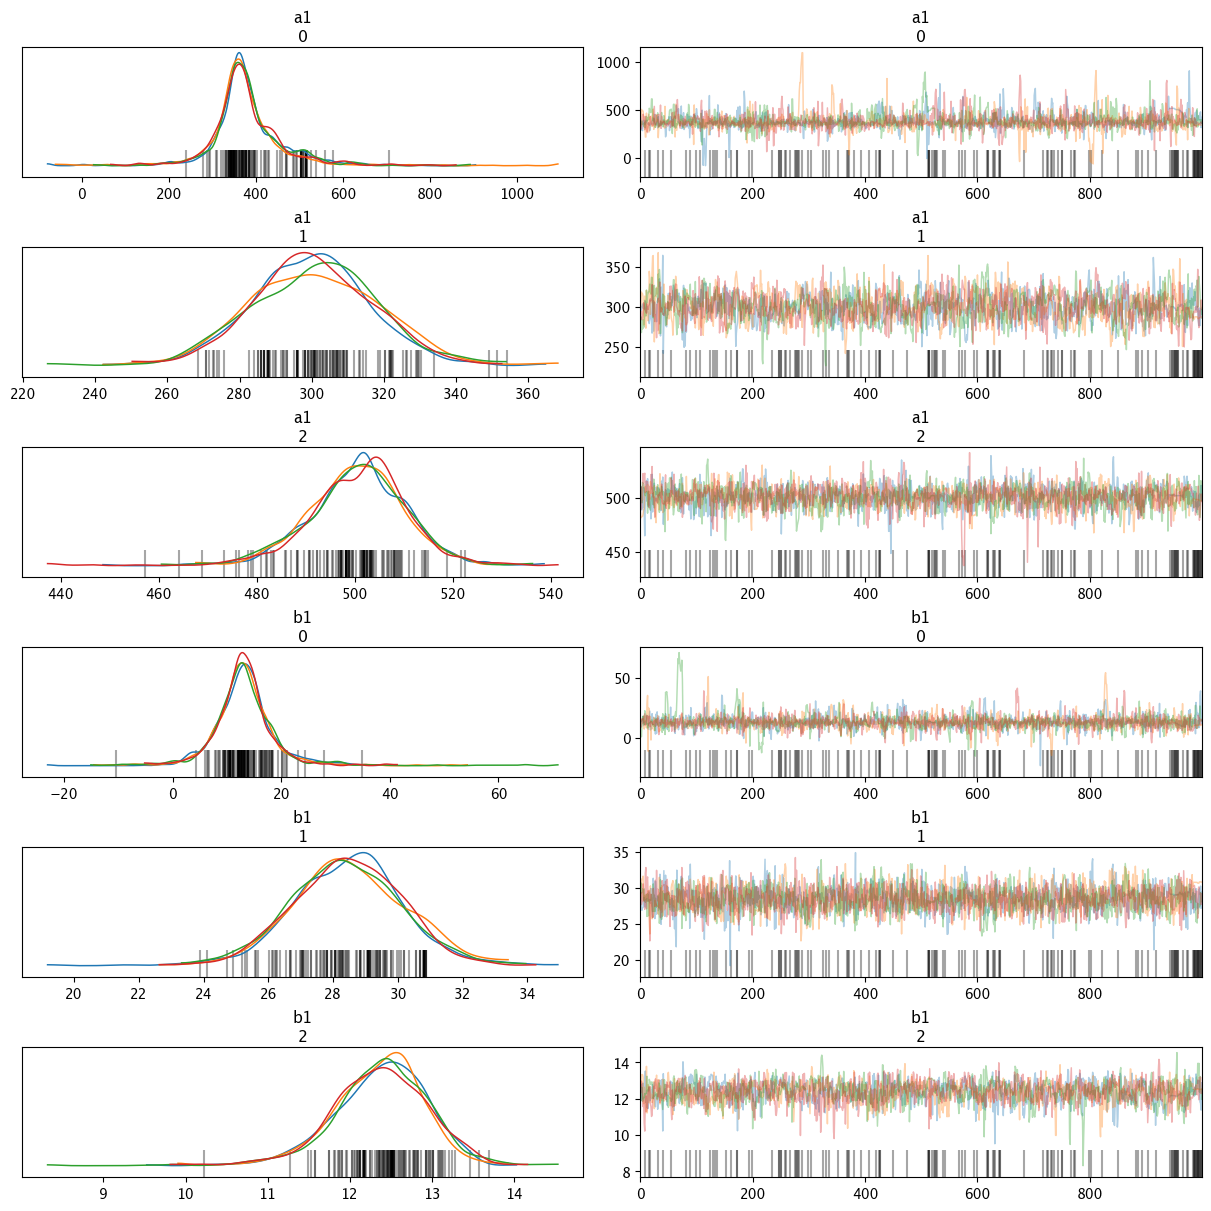

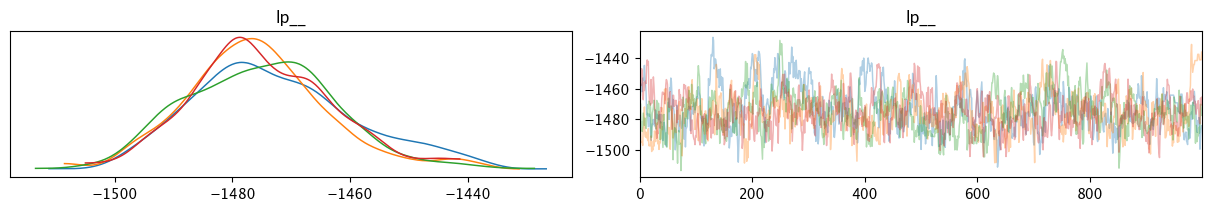

In [301]:
from pathlib import Path

import arviz as az
import polars as pl
from cmdstanpy import CmdStanModel

"""model8-6.stanの実行"""
data_salary_3 = Path("chap08/input/data-salary-3.txt")
salary3_df = pl.read_csv(data_salary_3)

data = {
    "N": salary3_df.shape[0],
    "G": salary3_df["GID"].max(),
    "K": salary3_df["KID"].max(),
    "X": salary3_df["X"].to_list(),
    "Y": salary3_df["Y"].to_list(),
    "KID": salary3_df["KID"].to_list(),
    "K2G": salary3_df.unique(subset=["KID", "GID"], maintain_order=True)[
        "GID"
    ].to_list(),
    "GID": salary3_df["GID"].to_list(),
}
sm = CmdStanModel(stan_file="chap08/model/model8-6.stan")
fit = sm.sample(data=data, seed=12345)
fit.summary()

az.rcParams["plot.max_subplots"] = 200

cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit,
    log_likelihood="lp__",
)

ll_data = cmdstanpy_data.log_likelihood
az.plot_trace(
    cmdstanpy_data,
    var_names=["a1", "b1"],
    compact=False,
    backend_kwargs={"constrained_layout": True},
)
az.plot_trace(ll_data, compact=False, backend_kwargs={"constrained_layout": True})

## 8.3 非線形の階層モデル

[7.3節](chap07.ipynb#73-非線形の関係)の時系列データ: 患者に点滴で薬剤を投与する場合に、投与からの経過時間(hour)と薬の血中濃度Y(mg/mL)のデータ

上記のデータのサンプル数が16人分になった場合を考える。

[data-conc-2.txt](chap08/**input**/data-conc-2.txt)

- personID: 患者のID
- Time1~24: それぞれ1~24時間経過後のY(薬剤の血中濃度)の値

### 8.3.1 解析の目的とデータの分布の確認

目的:

[7.3節](chap07.ipynb#73-非線形の関係)を踏まえて、以下が知りたい
- それぞれの患者において、頭打ちになるYの値と、頭打ちになるまでの時間
- 患者差のばらつき
- 患者ごとの予測分布を作図する

患者ごとの折れ線グラフ図8.7(左)と、患者ごとの最終時点(24時間後)におけるYのヒストグラム図8.7(右)

最終時点でなくても、患者ごとの最大値や、95%点等を使っても良い。この図からは頭打ちのYは山形の分布とわかる。(正規分布かは不明)

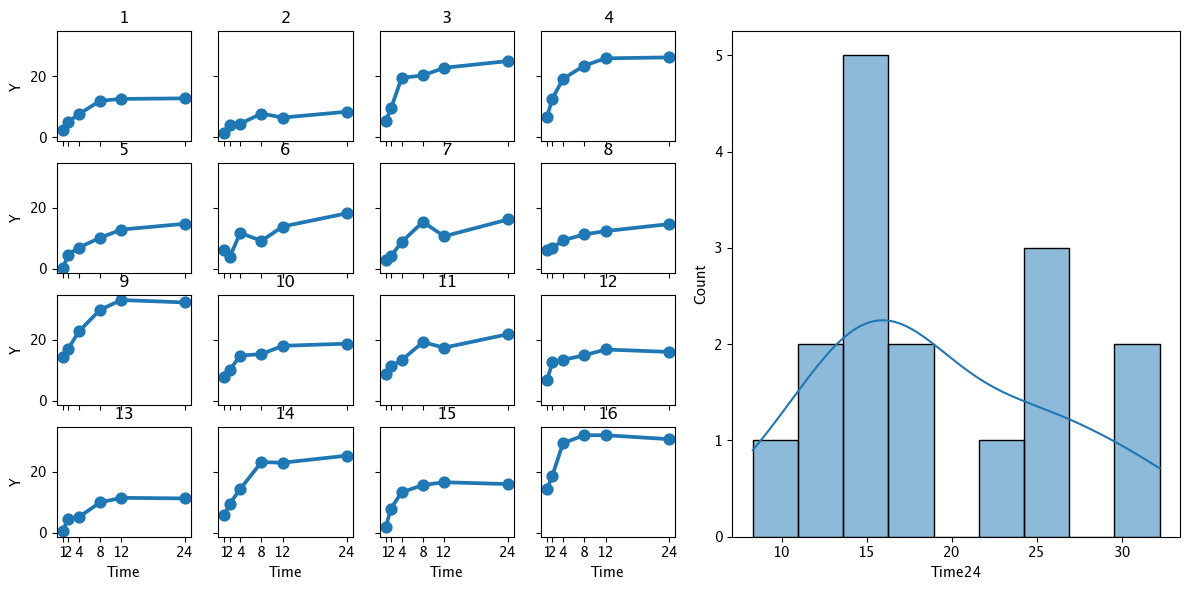

In [302]:
from pathlib import Path

import numpy as np
import polars as pl
import seaborn as sns
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

"""図8.7"""
path = Path("chap08/input/data-conc-2.txt")
conc2 = pl.read_csv("chap08/input/data-conc-2.txt")
Time = [int(name.replace("Time", "")) for name in conc2.columns[1:]]
person_id_list = conc2["PersonID"].cast(str).to_list()
conc2_t = (
    conc2.drop("PersonID")
    .transpose(
        include_header=False,
        column_names=person_id_list,
    )
    .with_columns(pl.Series(Time).alias("Time"))
)

fig = plt.figure(figsize=(12, 6))
# 左図のプロット
gs_master = GridSpec(4, 5, fig, width_ratios=[1, 1, 1, 1, 4])
gs_sub1 = GridSpecFromSubplotSpec(4, 4, gs_master[:, :4])
gs_subplot = gs_sub1.subplots(sharex="all", sharey="all")

for person_id, (row, col) in zip(person_id_list, np.ndindex(4, 4), strict=True):
    ax = fig.add_subplot(gs_subplot[row, col])
    ax.set_title(person_id)
    sns.pointplot(
        data=conc2_t,
        x="Time",
        native_scale=True,
        y=person_id,
        ax=ax,
    )
    ax.set_ylabel("Y")
    ax.set_xticks(Time)

# 右図のプロット
gs_sub2 = GridSpecFromSubplotSpec(
    1,
    1,
    gs_master[:, -1],
)

ax = fig.add_subplot(gs_sub2[:, :])
sns.histplot(conc2, x="Time24", kde=True, bins=9)

gs_master.tight_layout(fig)
plt.show()

### 8.3.2 メカニズムの想像

[7.3節](chap07.ipynb#73-非線形の関係)ではこのデータの背後のメカニズムを考慮し、曲線$y=a \{ 1 - \exp(-bt) \}$をあてはめた。

- t: 時間
- a: 頭打ちになるYの値
- b: 頭打ちになる時間
  
[8.1.3項](#813-グループごとに切片と傾きを持つ場合)のモデルを用いてもよいが、同様にグループ(この場合患者)によってデータが少ない場合に過学習が起こるなどが懸念される。ここでは以下を仮定して、階層モデルを適用する。

仮定
- $a[n], b[n]$は正の値のみとる
- 対数$log(a[n]), log(b[n])$が正規分布に従う

### 8.3.3 モデルの記述

モデル式8-7

- N: 患者数
- T: 測定回数(6)
- n: 患者のインデックス
- t: 測定時間のインデックス

$$
\begin{align}
    Y[n, t] &\sim \mathrm{Normal }(a[n] \{1 - \exp(-b[n] Time[t]) \}, \sigma_Y) \quad &n = 1, \ldots, N &\quad t = 1, \ldots, T \nonumber \\
    log(a[n]) &\sim \mathrm{Normal }(a_{全体平均}, \sigma_a) \quad &n = 1, \ldots, N \nonumber \\
    log(b[n]) &\sim \mathrm{Normal }(b_{全体平均}, \sigma_b) \quad &n = 1, \ldots, N \nonumber \\
\end{align}
$$

### 8.3.4 Stanで実装

Stan実装: [model8-7.stan](chap08/model/model8-7.stan)

Rで実行: [run-model8-7.R](chap08/run-model8-7.R)



In [303]:
from pathlib import Path

import numpy as np
import polars as pl
from cmdstanpy import CmdStanModel

path = Path("chap08/input/data-conc-2.txt")
conc2 = pl.read_csv("chap08/input/data-conc-2.txt")

Time = [int(col_name.replace("Time", "")) for col_name in conc2.columns[1:]]
T_new = 60
Time_new = np.linspace(0, 24, T_new)

data = {
    "N": conc2.shape[0],
    "T": len(Time),
    "Time": Time,
    "Y": conc2.drop("PersonID").to_numpy(),
    "T_new": T_new,
    "Time_new": Time_new,
}

sm = CmdStanModel(stan_file="chap08/model/model8-7.stan")
fit = sm.sample(data=data, seed=1234)
fit.summary()

23:50:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:50:39 - cmdstanpy - INFO - CmdStan done processing.
23:50:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/model/model8-7.stan', line 32, column 4 to column 31)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/model/model8-7.stan', line 31, column 4 to column 31)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/model/model8-7.stan', line 36, column 6 to column 58)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/model/model8-7.stan', line 31, column 4 to column 31)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/sean/Documen

Mean      MCSE    StdDev        5%       50%        95%  \
lp__         -84.64820  0.147282  5.180150 -93.68210 -84.26660 -76.954800   
a0             2.86247  0.001491  0.108672   2.68901   2.86306   3.036690   
b0            -1.17620  0.002068  0.123149  -1.38456  -1.17338  -0.986392   
log_a[1]       2.55986  0.001354  0.095572   2.40147   2.56176   2.713420   
log_a[2]       2.10992  0.002189  0.148916   1.86734   2.11267   2.350640   
...                ...       ...       ...       ...       ...        ...   
y_new[16,56]  31.88180  0.030629  1.937180  28.80330  31.85440  35.125400   
y_new[16,57]  31.88840  0.032679  1.965410  28.73370  31.88720  35.253200   
y_new[16,58]  31.87850  0.030383  1.958960  28.65720  31.88330  35.172500   
y_new[16,59]  31.87180  0.029996  1.958850  28.66980  31.85820  35.171600   
y_new[16,60]  31.92110  0.030120  1.968570  28.72170  31.94380  35.119300   

                N_Eff   N_Eff/s     R_hat  
lp__          1237.04   766.919  1.000830  
a0            5312.41  3293.500  0.999883  
b0            3546.18  2198.500  1.001160  
log_a[1]      4982.46  3088.940  0.999538  
log_a[2]      4626.53  2868.280  0.999588  
...               ...       ...       ...  
y_new[16,56]  4000.07  2479.890  0.999696  
y_new[16,57]  3617.24  2242.560  0.999316  
y_new[16,58]  4157.00  2577.180  0.999561  
y_new[16,59]  4264.68  2643.940  0.999775  
y_new[16,60]  4271.70  2648.300  0.999319  

[1030 rows x 9 columns]

### 8.3.5 推定結果の解釈

$\sigma_Y$以外は対数スケールになっているが、MCMCサンプルを使って線形スケールに戻すこともできる。また、同じように各患者のa[n]とb[n]についても中央値と区間を算出できる。解析の目的の患者巻の差を知ることができたといえる。

患者ごとの予測分布を作図する。(図8.8)

/var/folders/f5/_tj1zvq95fx0wllynn0tpq800000gn/T/ipykernel_51022/737916020.py:36: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  az.plot_hdi(Time_new, hdi_data=az.hdi(y_new_2d, hdi_prob=0.95), ax=ax)
/var/folders/f5/_tj1zvq95fx0wllynn0tpq800000gn/T/ipykernel_51022/737916020.py:36: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  az.plot_hdi(Time_new, hdi_data=az.hdi(y_new_2d, hdi_prob=0.95), ax=ax)
/var/folders/f5/_tj1zvq95fx0wllynn0tpq800000gn/T/ipykernel_51022/737916020.py:36: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  az.plot_hdi(Time_new, hdi_data=az.hdi(y_new_2d, hdi_prob=0.95), ax=ax)
/var/folders/f5/_tj1zvq95fx0wllynn0tpq800000gn/T/ipykernel_51

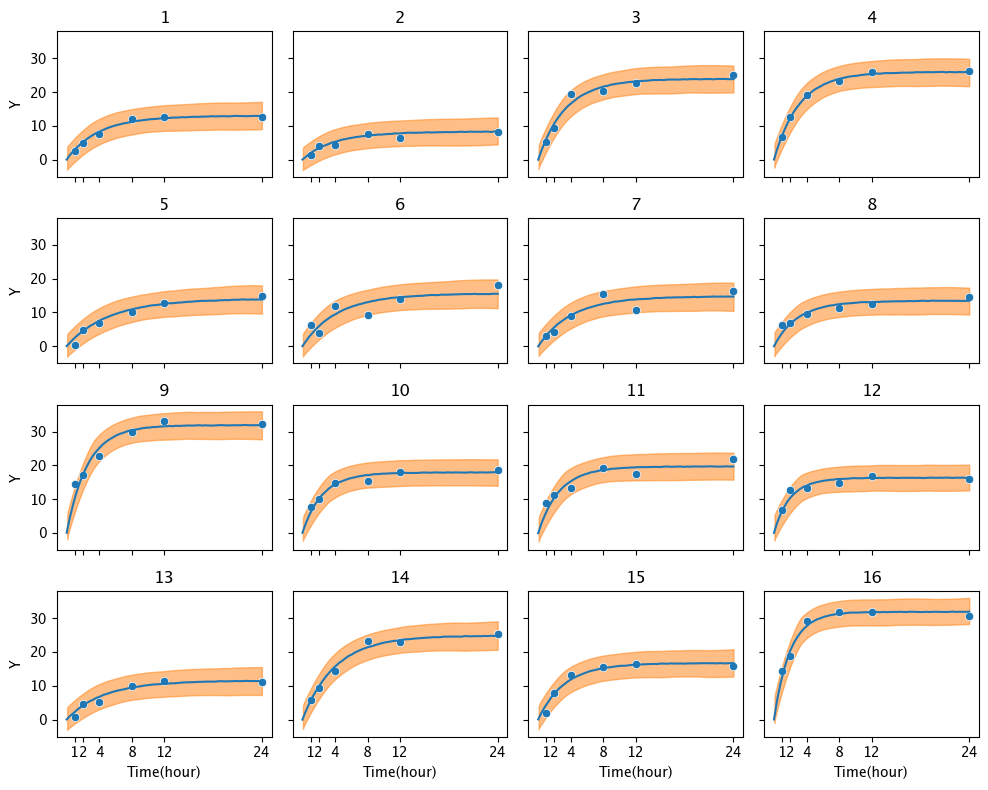

In [304]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

# 元データ読み込みと前処理
path = Path("chap08/input/data-conc-2.txt")
conc2 = pl.read_csv("chap08/input/data-conc-2.txt")
Time = [int(name.replace("Time", "")) for name in conc2.columns[1:]]
T_new = 60
Time_new = np.linspace(0, 24, T_new)
person_id_list = conc2["PersonID"].cast(str).to_list()
conc2_t = (
    conc2.drop("PersonID")
    .transpose(
        include_header=False,
        column_names=person_id_list,
    )
    .with_columns(pl.Series(Time).alias("Time"))
)

# グラフのレイアウト設定
fig = plt.figure(figsize=(10, 8))
axes = fig.subplots(4, 4, sharex="all", sharey="all")

# プロット
for ax, y_new_2d, person_id in zip(
    axes.flatten(),
    fit.y_new.transpose(1, 0, 2),
    person_id_list,
    strict=True,
):
    az.plot_hdi(Time_new, hdi_data=az.hdi(y_new_2d, hdi_prob=0.95), ax=ax)
    sns.scatterplot(conc2_t, x="Time", y=person_id, ax=ax)
    ax.plot(Time_new, np.median(y_new_2d, axis=0))
    ax.set_title(person_id)
    ax.set_xticks(Time)
    ax.set_xlabel("Time(hour)")
    ax.set_ylabel("Y")

plt.tight_layout()
plt.show()

### 8.4 ロジスティック回帰の階層モデル

[5.3節](chap05.ipynb#53-ロジスティック回帰)では学生の出血データに対し、以下のモデル式5-5でロジスティック回帰を行った。

モデル式5-5 (再掲)

- $A$: 学生がアルバイトが好きかを表す0/1の二値(0: 好きでない、1: 好き)
- $Score$: 学生の学問への興味の強さを数値化したもの(200点満点)
- $Weather$: 授業日の天気(A: 晴れ、B: 曇り、C: 雨)
- $Y$: 授業に出席したかどうかを表す0/1の二値（0：欠席、1：出席）

$$
\begin{align}
&q[i] = \mathrm{inv\_logit}(b_1 + b_2 A[i] + b_3 Score[i] + b_4 Weather[i]) &i = 1, ..., I \nonumber \\
&Y[i] \sim \mathrm{Bernoulli }(q[i]) &i = 1, ..., I \nonumber
\end{align}
$$

[5.3.5項](chap05.ipynb#535-モデル式の記述)で説明したように、このモデル式では同一の学生について複数回の出欠記録があることや、学生によって出席行動に差があること(学生差)を考慮していなかった。今回は経験的に考えられる以下の仮定を考慮する。

- 出欠確率qは学生差が大きそう
- 科目に人気があるかどうかの科目差も大きそう

この２つを考慮した階層モデルを考える。そのために新たに科目のID(CourseID)のデータを新たに取得した。

データは以下の２つ(データファイル5.3: [data-attendance-3.txt](chap05/input/data-attendance-3.txt)を学生に関するデータと出欠に関するデータに分割)

- データファイル8.4: [data-attendance-4-1.txt](chap08/input/data-attendance-4-1.txt)
- データファイル8.5: [data-attendance-4-2.txt](chap08/input/data-attendance-4-2.txt)


### 8.4.1 解析の目的

[5.3節](chap05.ipynb#53-ロジスティック回帰)とほぼ同じ。
- 与えられた説明変数から応答変数がどれほど予測できるか知りたい。
- それぞれの説明変数が出席確率にどれほど影響しているか知りたい。
- 学生差のバラツキと科目差のバラツキがどれほどか知りたい。

ここではデータの分布の確認は省略し、章末の練習問題とする。

### 8.4.2 メカニズムの想像

複数のID系列があって複雑な場合は、要素ごとに分けて考える。ここでは出席確率を決める要素を、

1. 学生に依存するもの: A・Score・学生差
2. 科目に依存するもの: 科目差
3. 一回ごとの授業に依存するもの: Weather

の3つに分けて考える。
そして、それぞれの要素については説明変数を使った回帰を行う。最終的に出席確率は、その要素の和をロジスティック関数で(0,1)の範囲に変換して算出されると考える。

### 8.4.3 モデルの記述

モデル式 8-8

- $N$: 学生の人数
- $n$: 学生のインデックス
- $I$: 出欠データ数
- $i$: 出欠データのインデックス
- $C$: 科目数
- $c$: 科目のインデックス
- $x_{学生}[n]$: 学生に依存する項。説明変数A, Scoreの線形結合に学生差を加えたもの
- $x_{科目}[c]$: 科目に依存する項。科目差
- $x_{授業}[i]$: １回毎の授業に依存する項。説明変数Weatherに比例

$$
\begin{align}
    X[i] &= b_1 + x_{学生}[PersonID[i]] + x_{科目}[CourseID[i]] + x_{授業}[i] \quad &i &= 1, \ldots, I \nonumber \\
    q[i] &= \mathrm{inv\_logit}(x[i]) \quad &i &= 1, \ldots, I \nonumber \\
    Y[i] &\sim \mathrm{Bernoulli}(q[i]) \quad &i &= 1, \ldots, I \nonumber \\
    x_{学生}[n] &= b_2 A[n] + b_3 Score[n] + b_{学生差}[n] \quad &n &= 1, \ldots, N \nonumber \\
    b_{学生差}[n] &\sim \mathrm{Normal }(0, \sigma_P) \quad &n &= 1, \ldots, N \nonumber \\
    x_{科目}[c] &= b_{科目差}[c] \quad &c &= 1, \ldots, C \nonumber \\
    b_{科目差}[c] &\sim \mathrm{Normal }(0, \sigma_C) \quad &c &= 1, \ldots, C \nonumber \\
    x_{授業}[i]  &= b_4 Weather[i] \quad &i &= 1, \ldots, I \nonumber
\end{align}
$$

$X[i]$の式のみに切片$b_1$が入っている。他の式に切片項を入れてしまうと$X[i]$に他の式を代入したときに切片が後が増え、その結果[7.4節](chap07.ipynb#73-非線形の関係)のように収束しなくなる。このような事例は[10.1節](chap10.ipynb)で再び扱う。

### 8.4.4 Stanで実装

実装: [model8-8.stan](chap08/model/model8-8.stan)

Rでの実行: [run-model8-8.R](chap08/run-model8-8.R)

23:50:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:51:08 - cmdstanpy - INFO - CmdStan done processing.
23:51:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/model/model8-8.stan', line 40, column 4 to column 28)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/model/model8-8.stan', line 40, column 4 to column 28)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/model/model8-8.stan', line 42, column 4 to column 28)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/model/model8-8.stan', line 40, column 4 to column 28)
Consider re-running with show_console=True if the above output is unclear!


array([[<Axes: title={'center': 'b_C'}>, <Axes: title={'center': 'b_C'}>]],
      dtype=object)

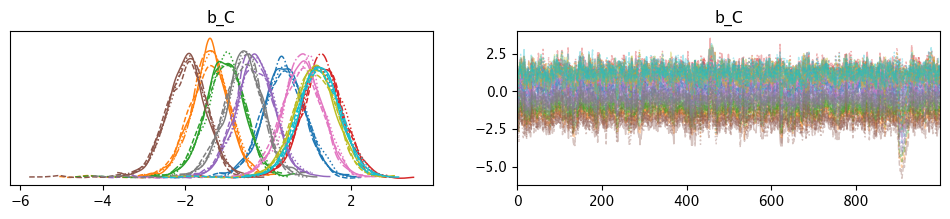

In [305]:
"""Pythonで実行8-8"""
import polars as pl
from cmdstanpy import CmdStanModel

path1 = "chap08/input/data-attendance-4-1.txt"
path2 = "chap08/input/data-attendance-4-2.txt"
attendance41 = pl.read_csv(path1)
attendance42 = pl.read_csv(path2)

# 天気を数値に変換
conv = {"A": "0.0", "B": "0.2", "C": "1.0"}
attendance42 = attendance42.with_columns(
    pl.col("Weather").replace(conv).cast(float),
)


data = {
    "N": attendance41.shape[0],
    "C": attendance42["CourseID"].max(),
    "I": attendance42.shape[0],
    "A": attendance41["A"].to_list(),
    "Score": (attendance41["Score"] / 200).to_list(),
    "PID": attendance42["PersonID"].to_list(),
    "CID": attendance42["CourseID"].to_list(),
    "W": attendance42["Weather"].to_list(),
    "Y": attendance42["Y"].to_list(),
}

# cmdstanにはparsなど推定する変数を指定する方法がない(大きく速くならないという判断).
# pars = ("b", "b_P", "b_C", "s_P", "s_C", "q")  # noqa: ERA001

sm = CmdStanModel(stan_file="chap08/model/model8-8.stan")
fit = sm.sample(data, seed=1234)
# Exception: normal_lpdf: Scale parameter is 0, but must be positive!について
# https://discourse.mc-stan.org/t/scale-parameter-is-0-but-must-be-0-can-i-do-anything-to-deal-with-this/19453

# fit.summary()

import arviz as az

az_data = az.from_cmdstanpy(fit)
az.plot_trace(az_data, var_names=["b_C"])

### 8.4.5 推定結果の解釈

MCMCサンプルを使って各パラメータの事後分布とベイズ信頼区間を描いた(図8.9)。

図8.9(左)からわかること
- $b_2$と$b_4$が同じぐらいの負の値: 「アルバイトが好き」と「天気が雨」が同程度のマイナスの影響
- $b_3$の分布は広くてなだらかだが95%ベイズ信頼区間に0が含まれておらず、中央値も2に近いので、Scoreの影響はプラス
- $\sigma_P$は0に近いことから学生差の影響は小さい
- $\sigma_C$は1より大きい確率が高く[<sup>2)</sup>](#fn2)、科目差の影響はかなり大きそうである。
 
図8.9(右)からわかること
- 最も出席率の高い科目のMAP推定値と最も低い科目のMAP推定値は3以上離れており、オッズで見るとexp(3)=20倍程度は差があることが分かる。

ちなみに [5.3.7項](chap05.ipynb#537-図によるモデルのチェック)で扱ったROC曲線を描いてAUCを計算すると、0.7945(80%ベイズ信頼区間は 0.7909～0.7975)になっており、学生差と科目差を考慮しなかった場合の約0.62と比べて改善したと言える。

このように階層モデルはロジスティック回帰などとも簡単に組み合わせることができる。出席率の他にも、例えば顧客の商品の購入確率のモデリングにおいても、顧客に依存する要素、商品に依存する要素、一回ごとの購買に依存する要素(天気、曜日等)があるので、同様のモデリングが可能だろう。

>[<sup id="fn2">2)</sup>](#fn2-back) 実際にMCMCサンプルから計算すると87%の確率で1より大きい。

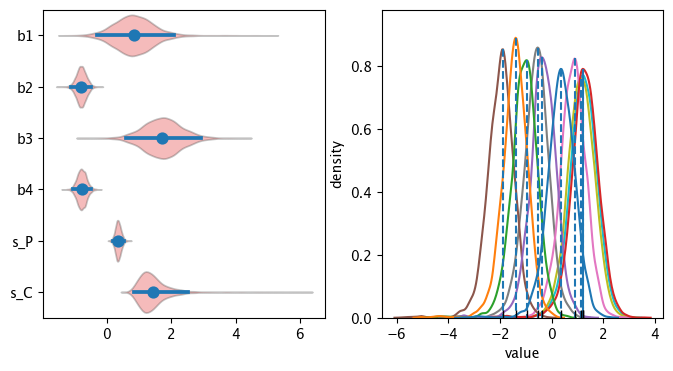

<Figure size 640x480 with 0 Axes>

In [306]:
# 推定されたノイズの分布
# cmdstanpy>=1.2.0で追加されたoptimize(sm.optimize(jacobian=True)によりMAP推定値が得られるが、その推定値がどれくらいの確率密度かは得られないので別途計算が必要
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# 左図
b_mcmc_df = pl.DataFrame(fit.b, schema=["b1", "b2", "b3", "b4"])
s_P_df = pl.DataFrame(fit.s_P, schema=["s_P"])
s_C_df = pl.DataFrame(fit.s_C, schema=["s_C"])
d = pl.concat([b_mcmc_df, s_P_df, s_C_df], how="horizontal")

sns.violinplot(
    d.to_dict(),
    density_norm="width",
    inner=None,
    orient="h",
    color="r",
    ax=ax1,
)
sns.pointplot(
    d.to_pandas(),
    orient="h",
    linestyle="",
    errorbar=("pi", 95),
    ax=ax1,
)

plt.setp(ax1.collections, alpha=0.3)

# 右図
# 各パラメータのMAP推定値の取得
"""
sm.optimizeがうまく収束しないため今回は使用しない
MAP_data = sm.optimize(
    data=data,
    algorithm="BFGS",
    jacobian=True,
    seed=123,
    iter=10000,
)
b_C_MAP = MAP_data.b_C
"""

b_C_mcmc = fit.b_C

"""
# b_C[c]の各MAP推定値と、その時の確率密度を取得
map_xy_list = []
for b_C_row, map_val in zip(b_C_mcmc.T, b_C_MAP, strict=True):  # noqa: N816
    kernel = stats.gaussian_kde(b_C_row)
    map_xy_list.append(kernel.pdf(map_val)[0])
"""

# b_C[c]の各MAP推定値と、その時の確率密度を取得
map_xy_list = []
for b_C_row in b_C_mcmc.T:
    kernel = stats.gaussian_kde(b_C_row)
    dens_x = np.linspace(b_C_row.min(), b_C_row.max(), kernel.n)
    dens_y = kernel.pdf(dens_x)  # 各xでの確率密度yを取得
    idx = np.argmax(dens_y)  # yの最大値のインデックスを取得
    mode_x = dens_x[idx]
    mode_y = dens_y[idx]
    map_xy_list.append([mode_x, mode_y])
map_xy_df = pl.DataFrame(map_xy_list, schema=["x", "y"])

sns.kdeplot(b_C_mcmc, ax=ax2, legend=False, common_norm=False)
ax2.vlines(map_xy_df["x"], map_xy_df["y"], 0, linestyles="dashed")
sns.rugplot(map_xy_df["x"], ax=ax2, color="k")
plt.setp(ax2, xlabel="value", ylabel="density")

plt.show()
plt.tight_layout()

plt.show()

## 補足と文献案内
階層モデル
- [19]久保拓弥、(2012).データ解析のための統計モデリング入門、岩波書店.
- [4]Gelman, A., & Jennifer, H. (2007). Data Analysis Using Regression and Multilevel/Hierarchical Models. Cambridge University Press.
  Stanで実装し直した第二版を計画中とのことである[<sup>3)</sup>](#fn3)。
- [6]K'eryMarc, Michael Schaub. (2016). BUGSで学ぶ階層モデリング入門. 共立出版.
  生態学における階層モデルと状態空間モデルを丁寧に扱っており、Rによるシミュレーションも豊富。この二つの本に関しては、本文中のBUGSコードをStanで実装し直したものが公式のGitHubリポジトリにある

## 練習問題
1. model8-2.stanの結果から，会社ごとに年収のベイズ予測区間を描け。
2. model8-3.stanの結果から、会社ごとに年収のベイズ予測区間を描け。
3. model8-5.stanの結果から、口業界平均［8］とb業界平均18］の事後分布を図8.9(左)を参考に描け。
4. [8.4節](#84-ロジスティック回帰の階層モデル)のデータの分布を確認せよ。具体的には、学生差を確認するために、学生ごとに出席率を求め、そのヒストグラムを描け。また、科目差を確認するために科目ごとに出席率を求め、そのヒストグラムを描け。
5. [8.4節](#84-ロジスティック回帰の階層モデル)で階層モデルを使わないで、すなわち$b_{学生差}[n]$および$b_{料目差}[n]$が正規分布の代わりに無情報事前分布に従うとして、推定してみよ。
6. 本書のGitHubリポジトリ上のchapo8/input/datara.csvのデータを使い[<sup>5)</sup>](#fn5)、二項ロジスティック回帰の階層モデルをStanで実装時、個体差の大きさを推定せよ。このデータファイルの構成は、調査した植物の個体ごとに行が分かれていて、id列は個体番号、y列が調査した8個中、生存していた種子数(応答変数)である。
7. 本書のGitHubリポジトリ上のchap08/input/d1.csvのデータを使い[<sup>6)</sup>](#fn6)、ポ
アソン回帰の階層モデルをStanで実装し、個体差と植木鉢差の大きさを推定せよ。このデータファイルの構成は、調査した植物の個体ごとに行が分かれていて、id列は個体番号、pot列は個体が植えられている植木鉢の番号、f列が処理の違い(説明変数その1)、y列が種子数(応答変数)である。

>[<sup id="fn3">3)</sup>](#fn3-back) http://andrewgelman.com/2015/06/11/applied-regression-and-multilevel-modeling-books-using-stan/
>
>[<sup id="fn4">4)</sup>](#fn4-back) https://github.com/stan-dev/example-models
>
>[<sup id="fn5">5)</sup>](#fn5-back) [19]の10章前半の例題データである。
>
>[<sup id="fn3">3)</sup>](#fn3-back) 同じ本の10章後半の例題データである。




11:32:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:32:39 - cmdstanpy - INFO - CmdStan done processing.


/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_p

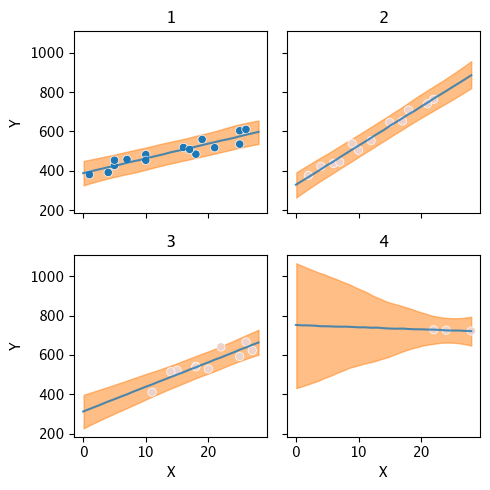

In [1]:
from pathlib import Path
from typing import Any

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from cmdstanpy import CmdStanMCMC, CmdStanModel

"""練習問題1"""
data_path = Path("chap08/input/data-salary-2.txt")
salary2 = pl.read_csv(data_path)
model8_2_path = Path("chap08/model/model8-2.stan")

K = salary2["KID"].unique_counts().shape[0]
data = {
    "N": salary2.shape[0],
    "K": K,
    "X": salary2["X"].to_list(),
    "Y": salary2["Y"].to_list(),
    "KID": salary2["KID"].to_list(),
}

sm1 = CmdStanModel(stan_file=model8_2_path)
fit1 = sm1.sample(data=data, seed=1234)


def generate_data(
    fit: CmdStanMCMC,
    x_new: list,
) -> tuple[pl.DataFrame, list[np.ndarray[Any, np.dtype[np.float64]]]]:
    """モデル8-2の事後予測データの作成."""
    result_df = pl.DataFrame(schema={"X": int, "Y": float, "KID": int})
    rng = np.random.default_rng(seed=1234)
    y_base_mcmc2_list = []
    for k in range(K):
        kid = k + 1
        # 基本年収Yの平均
        loc = fit.a[:, k].reshape((-1, 1)) + np.outer(fit.b[:, k], x_new)
        # 基本年収Yのばらつき
        scale = np.broadcast_to(fit.s_Y.reshape((-1, 1)), loc.shape)

        y_base_mcmc2 = rng.normal(loc, scale)
        y_base_mcmc2_list.append(y_base_mcmc2)
        y_new = np.median(y_base_mcmc2, axis=0)
        result_df = pl.concat(
            [result_df, pl.DataFrame({"X": x_new, "Y": y_new, "KID": kid})],
        )

    return result_df, y_base_mcmc2_list


x_new = np.arange(salary2["X"].max() + 1)
d, y_base_mcmc2_list = generate_data(fit1, x_new)
# 作図
fig = plt.figure(figsize=(5, 5))
axes = fig.subplots(2, 2, sharex="all", sharey="all")
for (kid, salary2_g_df), (_, grouped_df), (row, col) in zip(
    salary2.group_by("KID", maintain_order=True),
    d.group_by("KID", maintain_order=True),
    np.ndindex(2, 2),
    strict=True,
):
    ax = axes[row, col]
    ax.set_title(kid)

    # モデル8-2の95%ベイズ信頼区間と中央値
    az.plot_hdi(grouped_df["X"], y_base_mcmc2_list[kid - 1], hdi_prob=0.95, ax=ax)
    ax.plot("X", "Y", data=grouped_df, alpha=0.8, label="")

    # 会社毎の元データの散布図
    sns.scatterplot(
        salary2_g_df,
        x="X",
        y="Y",
        hue="KID",
        style="KID",
        legend=None,
        ax=ax,
    )

plt.tight_layout()
plt.show()

23:51:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:51:18 - cmdstanpy - INFO - CmdStan done processing.
23:51:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 iterations at max treedepth (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_p

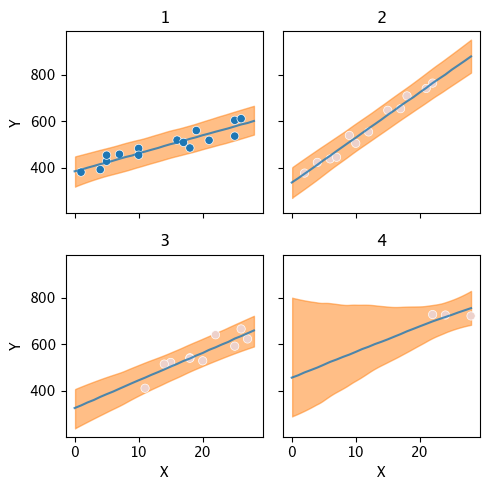

In [308]:
from pathlib import Path
from typing import Any

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from cmdstanpy import CmdStanMCMC, CmdStanModel

"""練習問題2"""
data_path = Path("chap08/input/data-salary-2.txt")
salary2 = pl.read_csv(data_path)
model8_3_path = Path("chap08/model/model8-3.stan")

K = salary2["KID"].unique_counts().shape[0]
data = {
    "N": salary2.shape[0],
    "K": K,
    "X": salary2["X"].to_list(),
    "Y": salary2["Y"].to_list(),
    "KID": salary2["KID"].to_list(),
}

sm2 = CmdStanModel(stan_file=model8_3_path)
fit2 = sm2.sample(data=data, seed=1234)


def generate_data(
    fit: CmdStanMCMC,
    x_new: list,
) -> tuple[pl.DataFrame, list[np.ndarray[Any, np.dtype[np.float64]]]]:
    """モデル8-3の事後予測データの作成."""
    result_df = pl.DataFrame(schema={"X": int, "Y": float, "KID": int})
    rng = np.random.default_rng(seed=1234)
    y_base_mcmc3_list = []
    for k in range(K):
        kid = k + 1
        # 基本年収Yの平均
        loc = fit.a[:, k].reshape((-1, 1)) + np.outer(fit.b[:, k], x_new)
        # 基本年収Yのばらつき
        scale = np.broadcast_to(fit.s_Y.reshape((-1, 1)), loc.shape)

        y_base_mcmc3 = rng.normal(loc, scale)
        y_base_mcmc3_list.append(y_base_mcmc3)
        y_new = np.median(y_base_mcmc3, axis=0)
        result_df = pl.concat(
            [result_df, pl.DataFrame({"X": x_new, "Y": y_new, "KID": kid})],
        )

    return result_df, y_base_mcmc3_list


x_new = np.arange(salary2["X"].max() + 1)
d3, y_base_mcmc3_list = generate_data(fit2, x_new)
# 作図
fig = plt.figure(figsize=(5, 5))
axes = fig.subplots(2, 2, sharex="all", sharey="all")
for (kid, salary2_g_df), (_, grouped_df), (row, col) in zip(
    salary2.group_by("KID", maintain_order=True),
    d3.group_by("KID", maintain_order=True),
    np.ndindex(2, 2),
    strict=True,
):
    ax = axes[row, col]
    ax.set_title(kid)

    # モデル8-3の95%ベイズ信頼区間(HDI)と中央値(CI)
    az.plot_hdi(grouped_df["X"], y_base_mcmc3_list[kid - 1], hdi_prob=0.95, ax=ax)
    ax.plot("X", "Y", data=grouped_df, alpha=0.8, label="")

    # 会社毎の元データの散布図
    sns.scatterplot(
        salary2_g_df,
        x="X",
        y="Y",
        hue="KID",
        style="KID",
        legend=None,
        ax=ax,
    )

plt.tight_layout()
plt.show()

23:51:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:51:22 - cmdstanpy - INFO - CmdStan done processing.
23:51:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 16 divergent transitions (1.6%)
	Chain 2 had 11 divergent transitions (1.1%)
	Chain 3 had 17 divergent transitions (1.7%)
	Chain 4 had 187 divergent transitions (18.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


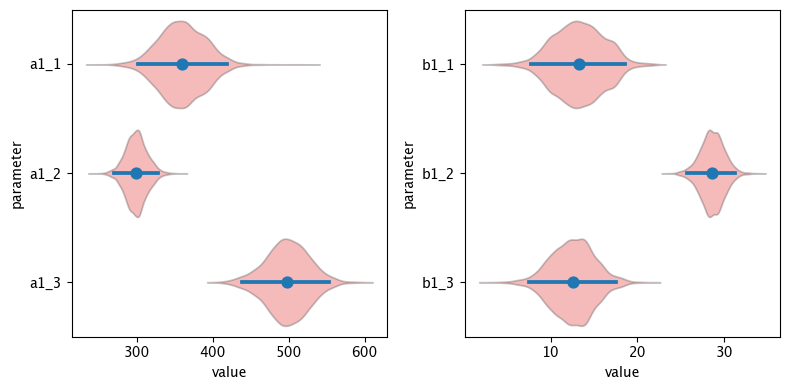

In [309]:
from pathlib import Path

import polars as pl
from cmdstanpy import CmdStanModel

"""練習問題3"""
data_salary_3 = Path("chap08/input/data-salary-3.txt")
salary3_df = pl.read_csv(data_salary_3)
model8_5_path = Path("chap08/model/model8-5.stan")

data = {
    "N": salary3_df.shape[0],
    "G": salary3_df["GID"].max(),
    "K": salary3_df["KID"].max(),
    "X": salary3_df["X"].to_list(),
    "Y": salary3_df["Y"].to_list(),
    "KID": salary3_df["KID"].to_list(),
    "K2G": salary3_df.unique(subset=["KID", "GID"], maintain_order=True)[
        "GID"
    ].to_list(),
}
sm5 = CmdStanModel(stan_file=model8_5_path)
fit5 = sm5.sample(data=data, seed=12345)

a1_mcmc_df = pl.DataFrame(fit5.a1, schema=["a1_1", "a1_2", "a1_3"])
b1_mcmc_df = pl.DataFrame(fit5.b1, schema=["b1_1", "b1_2", "b1_3"])

fig = plt.figure(figsize=(8, 4))
for df, ax in zip([a1_mcmc_df, b1_mcmc_df], fig.subplots(1, 2), strict=True):
    # 左図
    sns.violinplot(
        df.to_dict(),
        density_norm="width",
        inner=None,
        orient="h",
        color="r",
        ax=ax,
    )
    sns.pointplot(
        df.to_pandas(),
        orient="h",
        linestyle="",
        errorbar=("pi", 95),
        ax=ax,
    )
    plt.setp(ax.collections, alpha=0.3)
    ax.set_xlabel("value")
    ax.set_ylabel(ylabel="parameter")
plt.tight_layout()
plt.show()

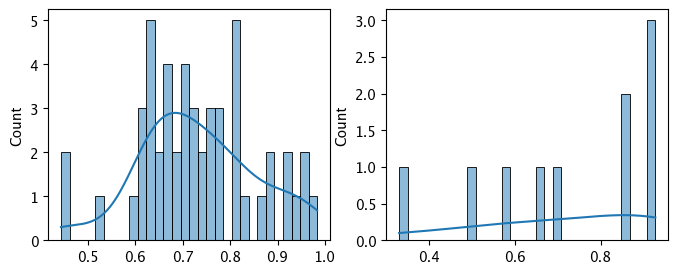

In [353]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

"""練習問題4"""
attendance41 = pl.read_csv("chap08/input/data-attendance-4-1.txt")
attendance42 = pl.read_csv("chap08/input/data-attendance-4-2.txt")

d_person = attendance42.group_by("PersonID").agg(
    pl.col("Y").sum() / pl.col("Y").count(),
)
d_course = attendance42.group_by("CourseID").agg(
    pl.col("Y").sum() / pl.col("Y").count(),
)

fig = plt.figure(figsize=(8, 3))
ax1, ax2 = fig.subplots(1, 2)
sns.histplot(d_person["Y"], binwidth=0.0180249804839969, kde=True, ax=ax1)
sns.histplot(d_course["Y"], binwidth=0.0199539512774807, kde=True, ax=ax2)
plt.show()

11:43:58 - cmdstanpy - INFO - compiling stan file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/exercise/ex5.stan to exe file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/exercise/ex5
11:44:14 - cmdstanpy - INFO - compiled model executable: /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/exercise/ex5
11:44:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:07 - cmdstanpy - INFO - CmdStan done processing.


11:45:08 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 995 divergent transitions (99.5%)
	Chain 2 had 986 divergent transitions (98.6%)
	Chain 3 had 994 divergent transitions (99.4%)
	Chain 4 had 976 divergent transitions (97.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


array([[<Axes: title={'center': 'b_C'}>, <Axes: title={'center': 'b_C'}>]],
      dtype=object)

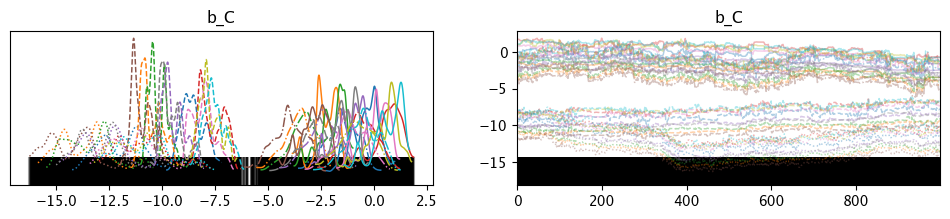

In [354]:
import polars as pl
from cmdstanpy import CmdStanModel

"""練習問題4"""
path1 = "chap08/input/data-attendance-4-1.txt"
path2 = "chap08/input/data-attendance-4-2.txt"
attendance41 = pl.read_csv(path1)
attendance42 = pl.read_csv(path2)

# 天気を数値に変換
conv = {"A": "0.0", "B": "0.2", "C": "1.0"}
attendance42 = attendance42.with_columns(
    pl.col("Weather").replace(conv).cast(float),
)

data = {
    "N": attendance41.shape[0],
    "C": attendance42["CourseID"].max(),
    "I": attendance42.shape[0],
    "A": attendance41["A"].to_list(),
    "Score": (attendance41["Score"] / 200).to_list(),
    "PID": attendance42["PersonID"].to_list(),
    "CID": attendance42["CourseID"].to_list(),
    "W": attendance42["Weather"].to_list(),
    "Y": attendance42["Y"].to_list(),
}

sm = CmdStanModel(stan_file="chap08/exercise/ex5.stan")
fit = sm.sample(data, seed=1234)
# Exception: normal_lpdf: Scale parameter is 0, but must be positive!について
# https://discourse.mc-stan.org/t/scale-parameter-is-0-but-must-be-0-can-i-do-anything-to-deal-with-this/19453

# fit.summary()

import arviz as az

az_data = az.from_cmdstanpy(fit)
az.plot_trace(az_data, var_names=["b_C"])

11:55:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:55:35 - cmdstanpy - INFO - CmdStan done processing.
11:55:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/exercise/ex6.stan', line 20, column 4 to column 28)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/exercise/ex6.stan', line 20, column 4 to column 28)
Consider re-running with show_console=True if the above output is unclear!


array([[<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'b_I'}>, <Axes: title={'center': 'b_I'}>],
       [<Axes: title={'center': 's_I'}>, <Axes: title={'center': 's_I'}>],
       [<Axes: title={'center': 'q'}>, <Axes: title={'center': 'q'}>]],
      dtype=object)

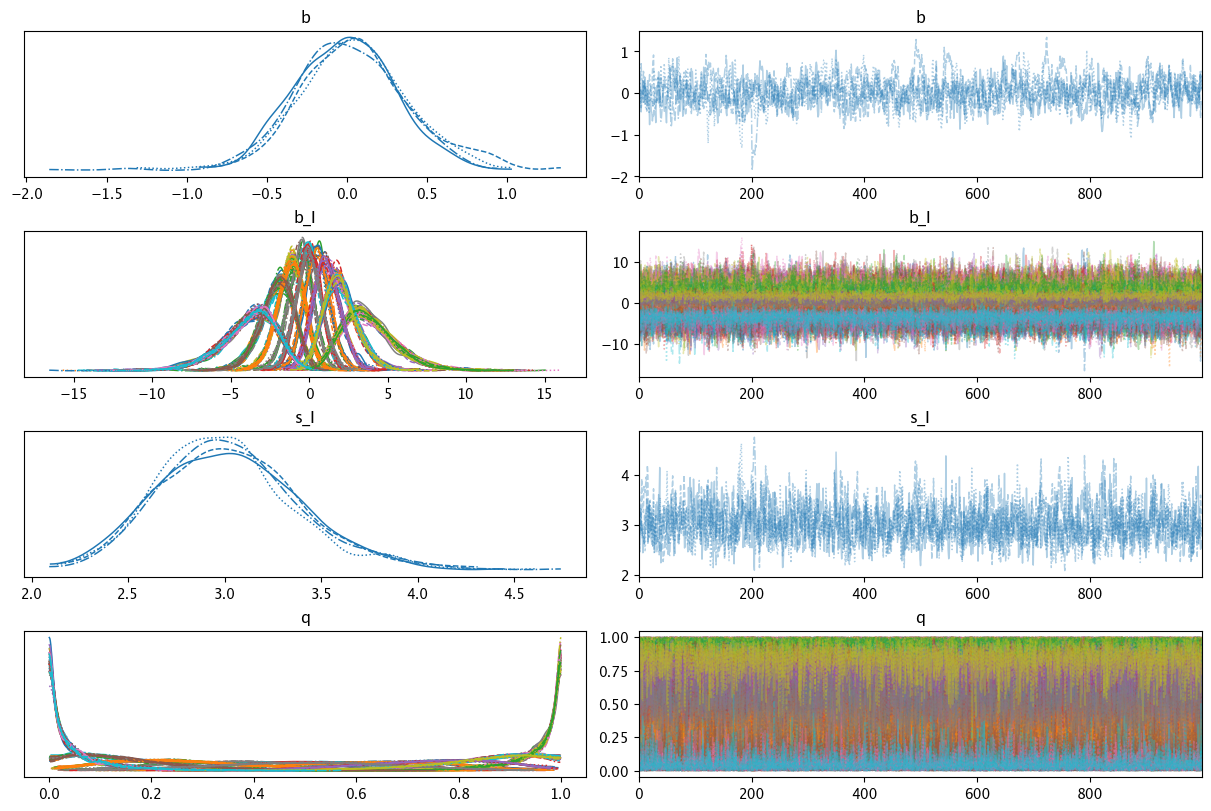

In [360]:
import polars as pl
from cmdstanpy import CmdStanModel

"""練習問題6"""
path = "chap08/input/data7a.csv"
d = pl.read_csv(path)

data = {
    "N": d.shape[0],
    "Y": d["y"].to_list(),
}
sm = CmdStanModel(stan_file="chap08/exercise/ex6.stan")
fit = sm.sample(data, seed=1234)

import arviz as az

az_data = az.from_cmdstanpy(fit)
az.plot_trace(az_data, backend_kwargs={"constrained_layout": True})

12:39:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:39:13 - cmdstanpy - INFO - CmdStan done processing.
12:39:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/exercise/ex7.stan', line 19, column 4 to column 28)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap08/exercise/ex7.stan', line 19, column 4 to column 28)
Consider re-running with show_console=True if the above output is unclear!


array([[<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'b_I'}>, <Axes: title={'center': 'b_I'}>],
       [<Axes: title={'center': 'b_Pot'}>,
        <Axes: title={'center': 'b_Pot'}>],
       [<Axes: title={'center': 's_I'}>, <Axes: title={'center': 's_I'}>],
       [<Axes: title={'center': 's_Pot'}>,
        <Axes: title={'center': 's_Pot'}>]], dtype=object)

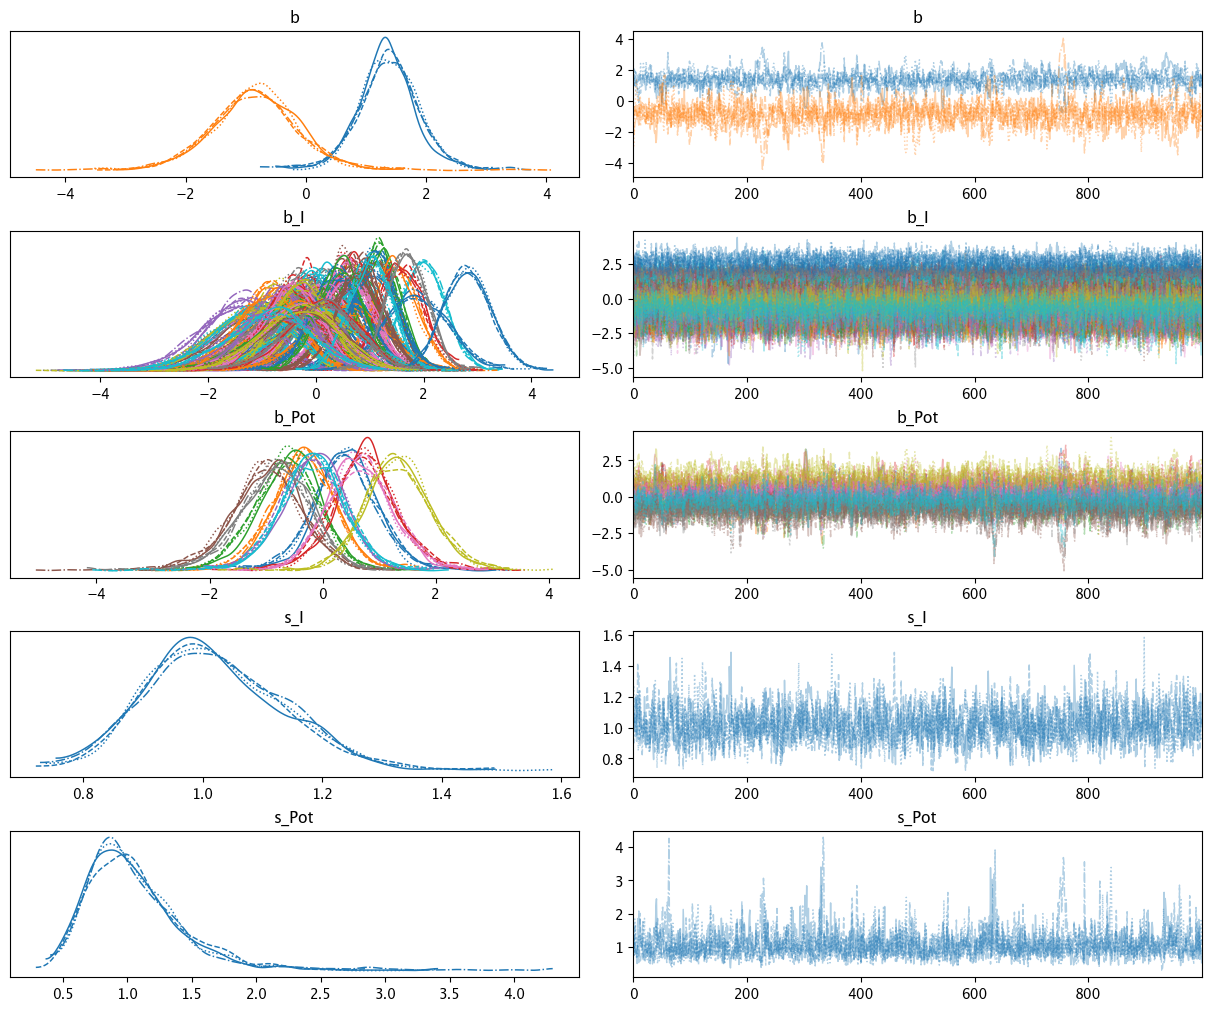

In [375]:
import polars as pl
from cmdstanpy import CmdStanModel

"""練習問題7"""
path = "chap08/input/d1.csv"
d1 = pl.read_csv(path)
N2Pot_dict = {
    key: str(val + 1)
    for key, val in zip(
        d1["pot"].unique(maintain_order=True),
        range(d1["pot"].n_unique()),
        strict=True,
    )
}
d1 = d1.with_columns(
    pl.col("f").replace({"C": "0", "T": "1"}).cast(int),
    pl.col("pot").replace(N2Pot_dict).cast(int).alias("N2Pot"),
)

data = {
    "N": d1.shape[0],
    "N_Pot": d1["pot"].n_unique(),
    "F": d1["f"].to_list(),
    "N2Pot": d1["N2Pot"].to_list(),
    "Y": d1["y"].to_list(),
}
sm = CmdStanModel(stan_file="chap08/exercise/ex7.stan")
fit = sm.sample(data, seed=1234)

import arviz as az

az_data = az.from_cmdstanpy(fit)
az.plot_trace(az_data, backend_kwargs={"constrained_layout": True})